In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.model_selection import (
    GroupShuffleSplit, GridSearchCV, GroupKFold, ParameterGrid
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.base import clone

# Import data

In [2]:
# Excel file path
excel_path = "Final_raw_dataset.xlsx"
xls = pd.ExcelFile(excel_path)

# Data Proprecessing

In [3]:
all_sheet_names = xls.sheet_names

# Each sheet rows
sheet_lengths = {}
for sheet in all_sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    sheet_lengths[sheet] = len(df)

# print("Length of each sheet:")
# for name, length in sheet_lengths.items():
#     print(f"{name}: {length} rows")

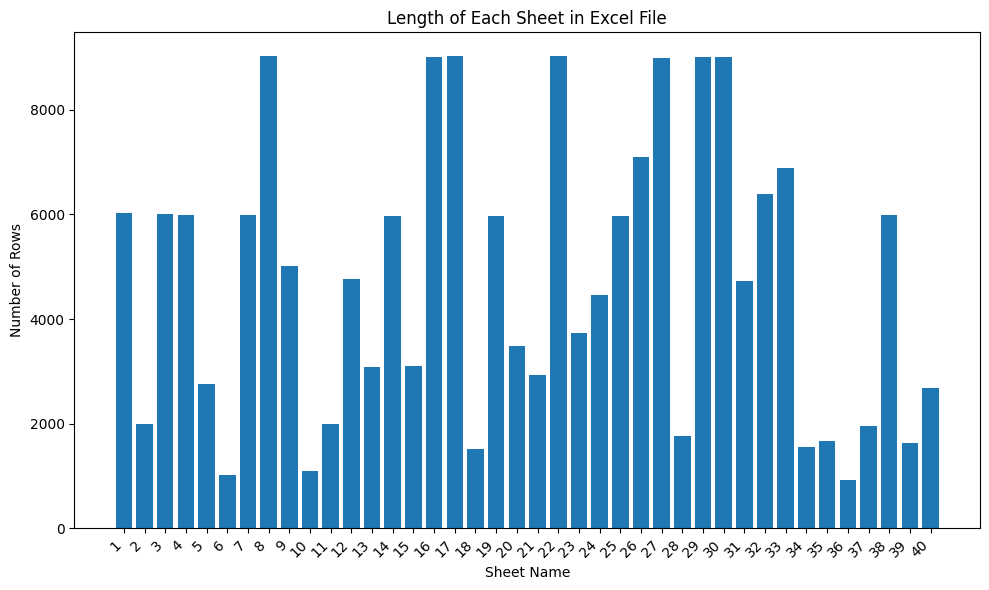

In [5]:
# Number of each of the 40 sheets
plt.figure(figsize=(10,6))
plt.bar(list(range(1,41)), sheet_lengths.values())
plt.xlabel('Sheet Name')
plt.ylabel('Number of Rows')
plt.title('Length of Each Sheet in Excel File')
plt.xticks(ticks=range(1, 41), labels=[str(i) for i in range(1, 41)], rotation=45, ha='right')
plt.tight_layout()

In [ ]:
# Find the sheets with the most and least data
min_sheet = min(sheet_lengths, key=sheet_lengths.get)
max_sheet = max(sheet_lengths, key=sheet_lengths.get)

print("\nSheet with the least number of rows:")
print(f"{min_sheet}: {sheet_lengths[min_sheet]} rows")

print("\nThe Sheet with the highest number of rows:")
print(f"{max_sheet}: {sheet_lengths[max_sheet]} rows")


Sheet with the least number of rows:
Chong: 929 rows

The Sheet with the highest number of rows:
Ida: 9030 rows


## Funtions

In [3]:
# Sliding Window Feature Extraction
def extract_window_features(df, window_size, step):
    """
    Extract statistical features from sliding windows over physiological signals.

    Args:
        df (pd.DataFrame): A DataFrame containing the columns 'O2Hb', 'HHb', and 'tHb' for a single subject's time-series data.
        window_size (int): The number of consecutive rows to include in each sliding window.
        step (int): The number of rows to move the window forward at each step.

    Returns:
        List[dict]: A list of dictionaries, each containing statistical features (mean, std, min, max, median) for 'O2Hb', 'HHb', and 'tHb' computed over each sliding window.
    """
    features = []
    for start in range(0, len(df) - window_size + 1, step):
        window = df.iloc[start:start + window_size]
        feature_dict = {
            'O2Hb_mean': window['O2Hb'].mean(),
            'O2Hb_std': window['O2Hb'].std(),
            'O2Hb_min': window['O2Hb'].min(),
            'O2Hb_max': window['O2Hb'].max(),
            'O2Hb_median': window['O2Hb'].median(),

            'HHb_mean': window['HHb'].mean(),
            'HHb_std': window['HHb'].std(),
            'HHb_min': window['HHb'].min(),
            'HHb_max': window['HHb'].max(),
            'HHb_median': window['HHb'].median(),

            'tHb_mean': window['tHb'].mean(),
            'tHb_std': window['tHb'].std(),
            'tHb_min': window['tHb'].min(),
            'tHb_max': window['tHb'].max(),
            'tHb_median': window['tHb'].median(),
        }
        features.append(feature_dict)
    return features

In [4]:
def unify_dataset_length(sheet_names, window_size, step):
    """
    Extracts and aligns sliding window features from multiple subjects' data to have the same number of windows per subject.

    Args:
        sheet_names (List[str]): A list of sheet names to parse from the Excel file. Each sheet corresponds to one subject's time-series data.
        window_size (int): The number of time points included in each sliding window.
        step (int): The step size for moving the window across time-series data.

    Returns:
        pd.DataFrame: A unified DataFrame containing sliding window features for all subjects, truncated to have the same number of windows (equal to the minimum across all subjects). Includes columns for statistical features, subject ID, label (0 for AB, 1 for SCI), and gender (1 for Male, 0 for Female).
        If any subject has no windows (i.e., not enough data), returns (-1, None).
    """
    all_features = {}
    min_windows = float('inf')  # Track the minimum number of windows across all subjects

    for idx, sheet in enumerate(sheet_names):
        df = xls.parse(sheet)
        features = extract_window_features(df, window_size, step)
        if len(features) == 0:
            return -1, None

        subject_id = idx + 1
        label = 1 if df['AB vs SCI'].iloc[0] == "SCI" else 0
        gender = 1 if df['Gender'].iloc[0] == "Male" else 0

        for feat in features:
            feat['Subject'] = subject_id
            feat['Label'] = label
            feat['Gender'] = gender

        all_features[subject_id] = features
        min_windows = min(min_windows, len(features))

    # Truncate all subjects to the same number of windows
    aligned_data = []
    for subject_id, feats in all_features.items():
        aligned_data.extend(feats[:min_windows])

    df_all = pd.DataFrame(aligned_data)
    return df_all

In [5]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [6]:
# Extracting features using two methods (compare)
def select_features(X, y, method='random_forest', k=8, feature_names=None):
    """
    Selects top-k features from the dataset using either Random Forest importance or SelectKBest with ANOVA F-score.

    Args:
        X (pd.DataFrame): Feature matrix of shape (n_samples, n_features).
        y (pd.Series): Target vector of shape (n_samples,).
        method (str): Feature selection method to use. Options are:
          - 'random_forest': Use feature importances from a trained RandomForestClassifier.
          - 'select_k_best': Use SelectKBest with ANOVA F-score (f_classif).
        k (int): The number of top features to select.
        feature_names (List[str]): List of feature names corresponding to columns in X.

    Returns:
        indices (List[int]): Indices of the selected top-k features.
        selected_features (List[str]): Names of the selected top-k features.
        selected_scores (List[Tuple[str, float]]): Tuples of (feature name, score) for the selected features,where the score is either feature importance (RF) or F-score (SKB).
    """
    scores = []
    if method == 'random_forest':
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1][:k]
        scores = importances
    elif method == 'select_k_best':
        skb = SelectKBest(score_func=f_classif, k=k)
        skb.fit(X, y)
        scores = skb.scores_
        indices = np.argsort(scores)[::-1][:k]
    else:
        raise ValueError("Invalid feature selection method.")

    selected_features = [feature_names[i] for i in indices]
    selected_scores = [(feature_names[i], scores[i]) for i in indices]
    return indices, selected_features, selected_scores

In [7]:
def evaluate_model_with_selection(df_all, model, feature_cols, k_values=[6, 8, 10], n_splits=3):
    X = df_all[feature_cols].values
    y = df_all['Label'].values
    groups = df_all['Subject'].values

    best_result = {
        'recall': 0,
        'method': None,
        'k': None,
        'selected_features': None,
        'selected_scores': None,
        'metrics': None
    }

    for method in ['random_forest', 'select_k_best']:
        for k in k_values:
            recalls, accuracies, precisions, f1s, rocs = [], [], [], [], []
            final_y_test, final_y_pred = None, None

            gkf = GroupKFold(n_splits=n_splits)
            try:
                for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    selected_indices, selected_features, selected_scores = select_features(
                        X_train, y_train, method=method, k=k, feature_names=feature_cols)

                    X_train_sel = X_train[:, selected_indices]
                    X_test_sel = X_test[:, selected_indices]

                    scaler = StandardScaler()
                    X_train_sel = scaler.fit_transform(X_train_sel)
                    X_test_sel = scaler.transform(X_test_sel)

                    model_clone = clone(model)
                    model_clone.fit(X_train_sel, y_train)
                    y_pred = model_clone.predict(X_test_sel)

                    try:
                        y_proba = model_clone.predict_proba(X_test_sel)[:, 1]
                        roc = roc_auc_score(y_test, y_proba)
                    except:
                        y_proba = np.zeros_like(y_pred)
                        roc = float('nan')

                    recalls.append(recall_score(y_test, y_pred, zero_division=0))
                    accuracies.append(accuracy_score(y_test, y_pred))
                    precisions.append(precision_score(y_test, y_pred, zero_division=0))
                    f1s.append(f1_score(y_test, y_pred, zero_division=0))
                    rocs.append(roc)

                    if fold_idx == n_splits - 1:
                        final_y_test = y_test
                        final_y_pred = y_pred

                mean_recall = np.mean(recalls)

                if mean_recall > best_result['recall']:
                    best_result.update({
                        'recall': mean_recall,
                        'method': method,
                        'k': k,
                        'selected_features': selected_features,
                        'selected_scores': selected_scores,
                        'metrics': {
                            'accuracy': np.mean(accuracies),
                            'precision': np.mean(precisions),
                            'f1': np.mean(f1s),
                            'roc_auc': np.nanmean(rocs),
                            'y_test': final_y_test,
                            'y_pred': final_y_pred
                        }
                    })
            except Exception as e:
                continue

    return best_result

## Test last 14 sheets

In [ ]:
# Test last sheets first
sheet_names = xls.sheet_names[-14:]

In [ ]:
window_size_list= [w for w in range(10, 101, 10)]
step_list = [s for s in range(10, 101, 10)]
k_values_list = [k for k in range(3, 16)]

In [ ]:
# Grid Search
param_grid = [(w, s) for w in window_size_list for s in step_list]

feature_cols = [
    'O2Hb_mean', 'O2Hb_std', 'O2Hb_min', 'O2Hb_max', 'O2Hb_median',
    'HHb_mean', 'HHb_std', 'HHb_min', 'HHb_max', 'HHb_median',
    'tHb_mean', 'tHb_std', 'tHb_min', 'tHb_max', 'tHb_median'
]

# Save results
results = []

In [ ]:
for window_size, step in tqdm(param_grid, desc='Grid Search'):
    df_all = unify_dataset_length(sheet_names, window_size, step)
    if isinstance(df_all, int) and df_all == -1:
        continue

    for model_name, base_model in models.items():
        model = clone(base_model)
        try:
            result = evaluate_model_with_selection(df_all, model, feature_cols, k_values=k_values_list)
            results.append({
                'Model': model_name,
                'Window': window_size,
                'Step': step,
                'Recall': result['recall'],
                'F1': result['metrics']['f1'],
                'Accuracy': result['metrics']['accuracy'],
                'Precision': result['metrics']['precision'],
                'ROC_AUC': result['metrics']['roc_auc'],
                'SelectedFeatures': ", ".join(result['selected_features']),
                'FeatureSelectionMethod': result['method'],
                'FeatureScores': result['selected_scores'],
                'Best_k': result['k']
            })
        except Exception as e:
            print(f"[Skipped] {model_name} - w:{window_size} s:{step} -> {e}")
            continue

Grid Search: 100%|██████████| 100/100 [2:13:37<00:00, 80.17s/it]


In [ ]:
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Recall'].idxmax()]
print("Best Result:")
print(best_result)
print("\nSelected Features in Best Result:")
print(best_result['SelectedFeatures'])
print("\nFeature Selection Method Used:")
print(best_result['FeatureSelectionMethod'])
print(f"\nBest k: {best_result['Best_k']}")
print("\nFeature Scores:")
for feat, score in best_result['FeatureScores']:
    print(f"{feat}: {score:.4f}")

Best Result:
Model                                                                   SVC
Window                                                                   30
Step                                                                     80
Recall                                                                0.875
F1                                                                 0.756475
Accuracy                                                           0.726389
Precision                                                          0.685045
ROC_AUC                                                            0.753472
SelectedFeatures          HHb_std, O2Hb_max, tHb_max, tHb_min, tHb_media...
FeatureSelectionMethod                                        random_forest
FeatureScores             [(HHb_std, 0.11690638380078712), (O2Hb_max, 0....
Best_k                                                                   11
Name: 163, dtype: object

Selected Features in Best Result:
HHb_std, O2Hb_m

In [ ]:
results_df.shape

(600, 12)

In [8]:
def evaluate_model_result(df, model, feature_cols, best_window=None, best_step=None, n_splits=3):
    """
    Train and evaluate a classification model using GroupKFold cross-validation.
    Standard scaling is applied to features before training. Metrics are averaged across folds,
    and test results from the last fold are returned for further inspection or visualization.

    Args:
        df (pd.DataFrame): Input dataset containing feature columns, 'Label' (target),
            and 'Subject' (group identifier for GroupKFold).
        model (sklearn classifier): A scikit-learn compatible classification model
            with fit/predict methods.
        feature_cols (List[str]): List of column names to be used as features.
        best_window (int, optional): The sliding window size used for data generation (for record keeping).
        best_step (int, optional): The sliding window step used for data generation (for record keeping).
        n_splits (int): Number of folds for GroupKFold cross-validation. Default is 3.

    Returns:
        tuple:
            recall (float): Average recall score across all folds.
            accuracy (float): Average accuracy score across all folds.
            precision (float): Average precision score across all folds.
            roc_auc (float): Average ROC AUC score across all folds. Returns NaN if unavailable.
            f1 (float): Average F1 score across all folds.
            y_test (np.ndarray): True labels from the last fold.
            y_pred (np.ndarray): Predicted labels from the last fold.
    """
    X = df[feature_cols].values
    y = df['Label'].values
    groups = df['Subject'].values

    gkf = GroupKFold(n_splits=n_splits)

    recall_list, accuracy_list, precision_list, roc_auc_list, f1_list = [], [], [], [], []

    # Last Fold Forecast Results
    last_y_test, last_y_pred = None, None

    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        try:
            y_proba = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        except:
            y_proba = np.zeros_like(y_pred)
            roc_auc = float('nan')

        recall = recall_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        recall_list.append(recall)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

        # Return Last Fold Result
        if fold_idx == n_splits - 1:
            last_y_test = y_test
            last_y_pred = y_pred

    # Return to Average Indicator + Last Fold Forecast Result
    return (
        np.mean(recall_list),
        np.mean(accuracy_list),
        np.mean(precision_list),
        np.nanmean(roc_auc_list),
        np.mean(f1_list),
        last_y_test,
        last_y_pred
    )


In [ ]:
# sheet_names = xls.sheet_names[-14:]
df_best_result_14 = unify_dataset_length(sheet_names, best_result["Window"], best_result["Step"])

In [ ]:
df_best_result_14.shape #9 pieces of data per person, 18 columns

(168, 18)

In [ ]:
df_best_result_14.columns

Index(['O2Hb_mean', 'O2Hb_std', 'O2Hb_min', 'O2Hb_max', 'O2Hb_median',
       'HHb_mean', 'HHb_std', 'HHb_min', 'HHb_max', 'HHb_median', 'tHb_mean',
       'tHb_std', 'tHb_min', 'tHb_max', 'tHb_median', 'Subject', 'Label',
       'Gender'],
      dtype='object')

In [ ]:
keep_columns = [i.strip() for i in best_result["SelectedFeatures"].split(",")]
print(keep_columns)

['HHb_std', 'O2Hb_max', 'tHb_max', 'tHb_min', 'tHb_median', 'O2Hb_median', 'tHb_mean', 'O2Hb_mean', 'HHb_max', 'O2Hb_min', 'HHb_median']


In [ ]:
df_best_result_14_columns = ['Subject', 'Label', 'Gender'] + keep_columns
print(df_best_result_14_columns)

['Subject', 'Label', 'Gender', 'HHb_std', 'O2Hb_max', 'tHb_max', 'tHb_min', 'tHb_median', 'O2Hb_median', 'tHb_mean', 'O2Hb_mean', 'HHb_max', 'O2Hb_min', 'HHb_median']


In [ ]:
df_best_result_14 = df_best_result_14[df_best_result_14_columns]
df_best_result_14.head(3)

,Subject,Label,Gender,HHb_std,O2Hb_max,tHb_max,tHb_min,tHb_median,O2Hb_median,tHb_mean,O2Hb_mean,HHb_max,O2Hb_min,HHb_median
0,1,0,1,0.742575,-4.887311,-7.499223,-11.859887,-11.143083,-8.139920,-10.796987,-8.090840,-1.087685,-10.503465,-2.906189
1,1,0,1,1.261052,-9.034932,-3.876664,-8.885316,-7.949094,-14.105620,-7.567584,-13.876289,8.943481,-17.214355,6.156525
2,1,0,1,1.124409,-9.710225,-0.225511,-7.099900,-5.480500,-15.627242,-5.019794,-15.316948,12.523102,-19.147354,10.146744


In [ ]:
best_result_recall, best_result_accuracy, best_result_precision, best_result_roc_auc, best_result_f1, best_result_y_test, best_result_y_pred = evaluate_model_result(
    df_best_result_14,
    models[best_result["Model"]],
    keep_columns,
    best_result["Window"],
    best_result["Step"]
  )

In [ ]:
print("Classification Report for Best Model:")
print(f"Model: {best_result['Model']}, Window: {best_result['Window']}, Step: {best_result['Step']}")

print(classification_report(best_result_y_test, best_result_y_pred, target_names=["AB", "SCI"]))

Classification Report for Best Model:
Model: SVC, Window: 30, Step: 80
              precision    recall  f1-score   support

          AB       1.00      0.46      0.63        24
         SCI       0.65      1.00      0.79        24

    accuracy                           0.73        48
   macro avg       0.82      0.73      0.71        48
weighted avg       0.82      0.73      0.71        48



In [ ]:
cm = confusion_matrix(best_result_y_test, best_result_y_pred)

<Figure size 800x600 with 0 Axes>

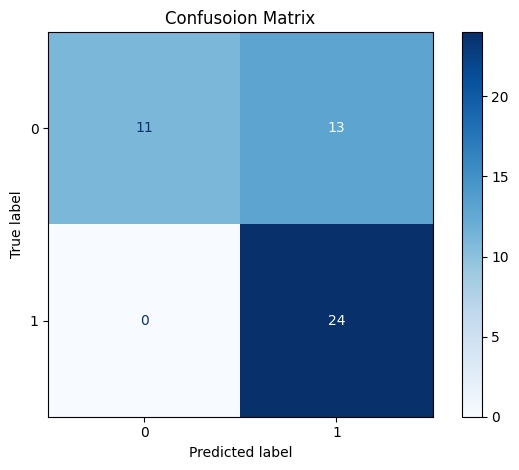

In [ ]:
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusoion Matrix')
plt.tight_layout()

## EDA

In [ ]:
print(f"Total amount of data: {(df_best_result_14.shape[0])}, has {(df_best_result_14.shape[1])} columns.\nTotal amount of patients: {len(df_best_result_14['Subject'].unique())}.\nNumber of AB:{len(df_best_result_14[df_best_result_14['Label']==0])}\nNumber of SCI:{len(df_best_result_14[df_best_result_14['Label']==1])}")

Total amount of data: 168, has 14 columns.
Total amount of patients: 14.
Number of AB:84
Number of SCI:84


In [ ]:
print(f"Female:{len(df_best_result_14[df_best_result_14['Gender']==0])}, Male:{len(df_best_result_14[df_best_result_14['Gender']==1])}")

Female:0, Male:168


Text(0.5, 1.0, 'Group Distribution (AB vs SCI)')

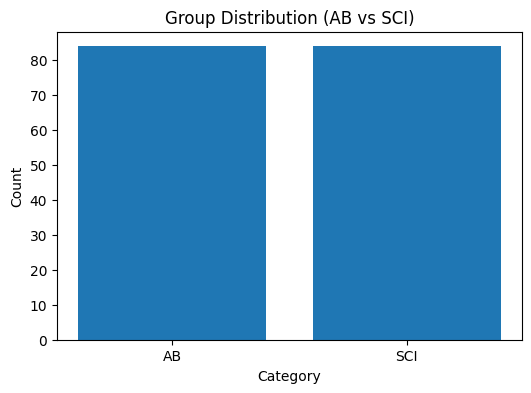

In [ ]:
# Draw a bar graph comparing the number of AB and SCI
plt.figure(figsize=(6, 4))

labels = df_best_result_14["Label"].value_counts().index
num = df_best_result_14['Label'].value_counts().values

label_names = ['AB' if val == 0 else 'SCI' for val in labels]
bars = plt.bar(label_names, num)

for bar, label in zip(bars, label_names):
    bar.set_label(label)

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Group Distribution (AB vs SCI)')

Text(0.5, 1.0, 'Group Distribution (Male vs Female)')

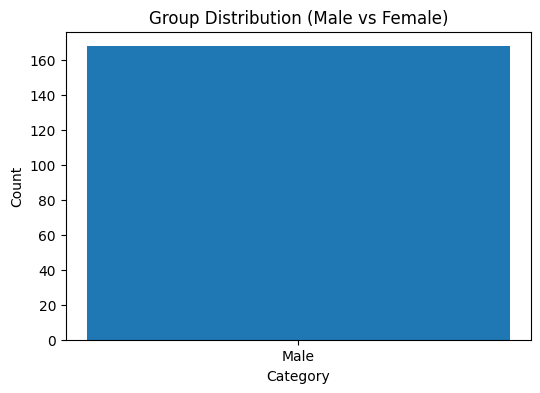

In [ ]:
# Draw a bar graph comparing the number of Male and Female
plt.figure(figsize=(6, 4))

labels = df_best_result_14["Gender"].value_counts().index
num = df_best_result_14['Gender'].value_counts().values

label_names = ['Female' if val == 0 else 'Male' for val in labels]
bars = plt.bar(label_names, num)

for bar, label in zip(bars, label_names):
    bar.set_label(label)

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Group Distribution (Male vs Female)')

In [ ]:
df_best_result_14.columns

Index(['Subject', 'Label', 'Gender', 'HHb_std', 'O2Hb_max', 'tHb_max',
       'tHb_min', 'tHb_median', 'O2Hb_median', 'tHb_mean', 'O2Hb_mean',
       'HHb_max', 'O2Hb_min', 'HHb_median'],
      dtype='object')

In [ ]:
O2Hb_features_names = ['O2Hb_max', 'O2Hb_median', 'O2Hb_mean', 'O2Hb_min']
HHb_features_names = ['HHb_std', 'HHb_max', 'HHb_median']
tHb_features_names = ['tHb_max', 'tHb_min', 'tHb_median', 'tHb_mean']

In [ ]:
def plot_features_vs_label(df, feature_cols, title="Distribution of O2Hb Features by Label"):
    """
    Plots boxplots of specified features grouped by label to visualize their distributions.

    Args:
        df (pd.DataFrame): Input DataFrame containing feature columns and a 'Label' column.
        feature_cols (List[str]): A list of feature column names to be plotted.
        title (str, optional): Title of the plot. Default is "Distribution of O2Hb Features by Label".

    Returns:
        None. Displays a boxplot for each feature, grouped by class label.
    """
    df_melted = df.melt(id_vars='Label', value_vars=feature_cols, var_name='Feature', value_name='Value')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x='Feature', y='Value', hue='Label')
    plt.title(title)
    plt.legend(title='Label')
    plt.tight_layout()

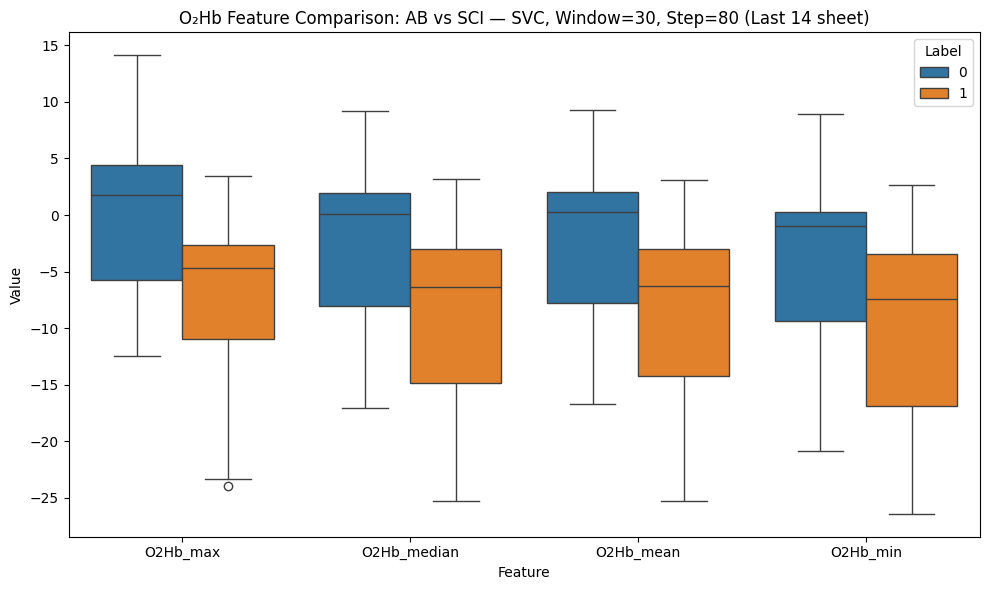

In [ ]:
plot_features_vs_label(df_best_result_14, O2Hb_features_names, "O₂Hb Feature Comparison: AB vs SCI — SVC, Window=30, Step=80 (Last 14 sheet)")

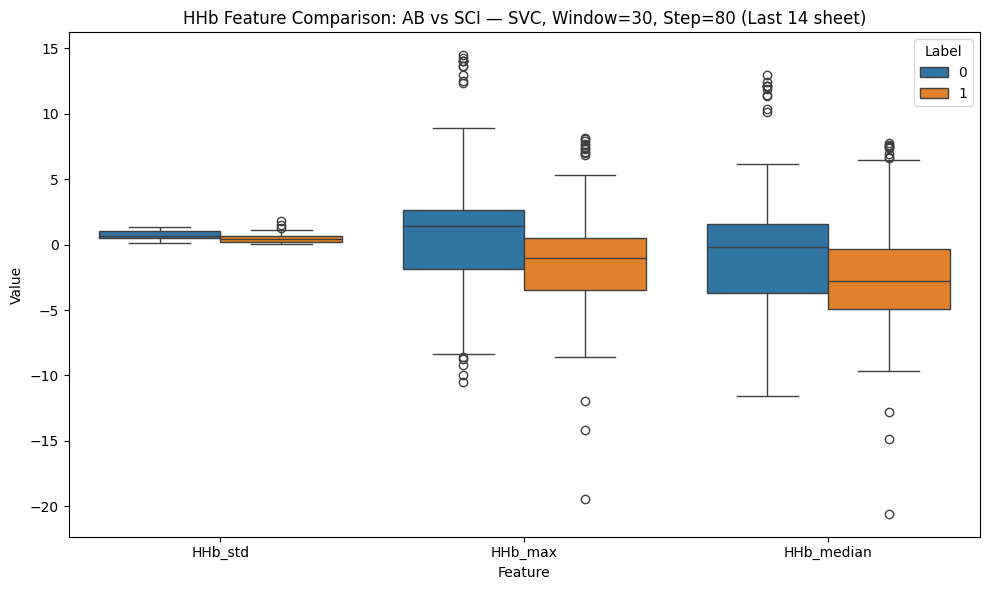

In [ ]:
plot_features_vs_label(df_best_result_14, HHb_features_names, "HHb Feature Comparison: AB vs SCI — SVC, Window=30, Step=80 (Last 14 sheet)")

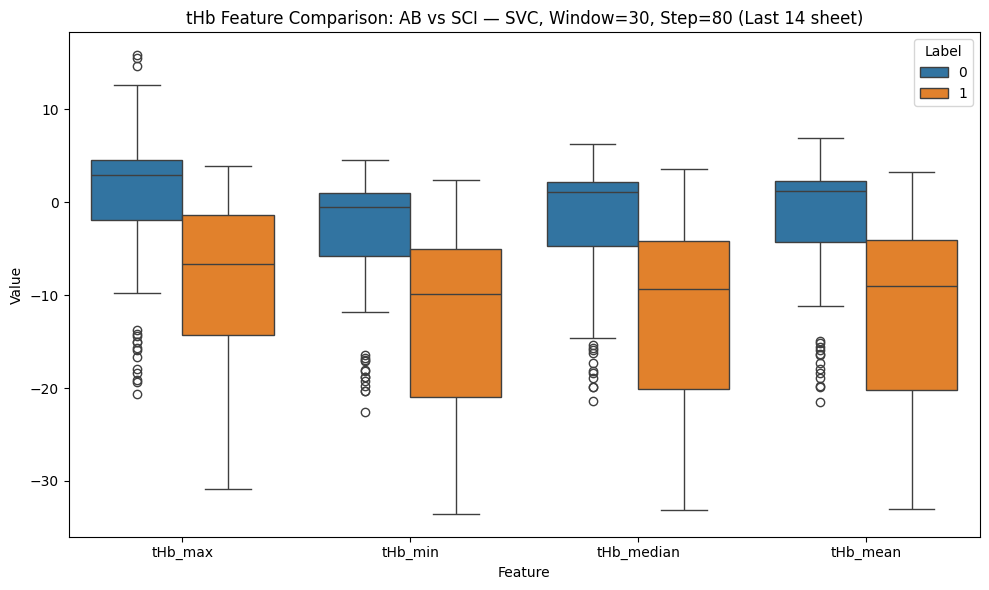

In [ ]:
plot_features_vs_label(df_best_result_14, tHb_features_names, "tHb Feature Comparison: AB vs SCI — SVC, Window=30, Step=80 (Last 14 sheet)")

## Split and use SMOTE to dataset

In [39]:
results_df = pd.read_csv("All_Param.csv")

In [74]:
# Aggregate statistics for F1 and Recall for each Window
summary_window = results_df.groupby('Window').agg({
    'F1': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std']
}).reset_index()

# Aggregate statistics for F1 and Recall for each Step
summary_step = results_df.groupby('Step').agg({
    'F1': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std']
}).reset_index()

# Aggregate statistics for F1 and Recall for each Best_k
summary_k = results_df.groupby('Best_k').agg({
    'F1': ['mean', 'std', 'count'],
    'Recall': ['mean', 'std']
}).reset_index()


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 假设 summary_window, summary_step, summary_k 已在外部处理好后传入

def plot_all_summaries(summary_window, summary_step, summary_k):
    """
    Plots line graphs showing the mean and standard deviation of F1-scores and Recall for different hyperparameters:
    window size, step size, and best_k (number of selected features).

    Combines F1-score and Recall into single plots per hyperparameter.
    """
    # Flatten column names if using MultiIndex
    summary_window.columns = ['_'.join(col).strip('_') for col in summary_window.columns.values]
    summary_step.columns = ['_'.join(col).strip('_') for col in summary_step.columns.values]
    summary_k.columns = ['_'.join(col).strip('_') for col in summary_k.columns.values]

    # Sort by hyperparameter values
    summary_window = summary_window.sort_values('Window')
    summary_step = summary_step.sort_values('Step')
    summary_k = summary_k.sort_values('Best_k')

    # Plot F1-score and Recall by Window Size
    plt.figure(figsize=(12, 6))
    plt.errorbar(summary_window['Window'], summary_window['F1_mean'], yerr=summary_window['F1_std'], fmt='-o', label='F1-score', color='red', capsize=5)
    plt.errorbar(summary_window['Window'], summary_window['Recall_mean'], yerr=summary_window['Recall_std'], fmt='-s', label='Recall', color='blue', capsize=5)
    plt.title('F1-score and Recall by Window Size')
    plt.xlabel('Window Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot F1-score and Recall by Step Size
    plt.figure(figsize=(12, 6))
    plt.errorbar(summary_step['Step'], summary_step['F1_mean'], yerr=summary_step['F1_std'], fmt='-o', label='F1-score', color='red', capsize=5)
    plt.errorbar(summary_step['Step'], summary_step['Recall_mean'], yerr=summary_step['Recall_std'], fmt='-s', label='Recall', color='blue', capsize=5)
    plt.title('F1-score and Recall by Step Size')
    plt.xlabel('Step Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Plot F1-score and Recall by Best_k
    plt.figure(figsize=(12, 6))
    plt.errorbar(summary_k['Best_k'], summary_k['F1_mean'], yerr=summary_k['F1_std'], fmt='-o', label='F1-score', color='red', capsize=5)
    plt.errorbar(summary_k['Best_k'], summary_k['Recall_mean'], yerr=summary_k['Recall_std'], fmt='-s', label='Recall', color='blue', capsize=5)
    plt.title('F1-score and Recall by Best k')
    plt.xlabel('Best k')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

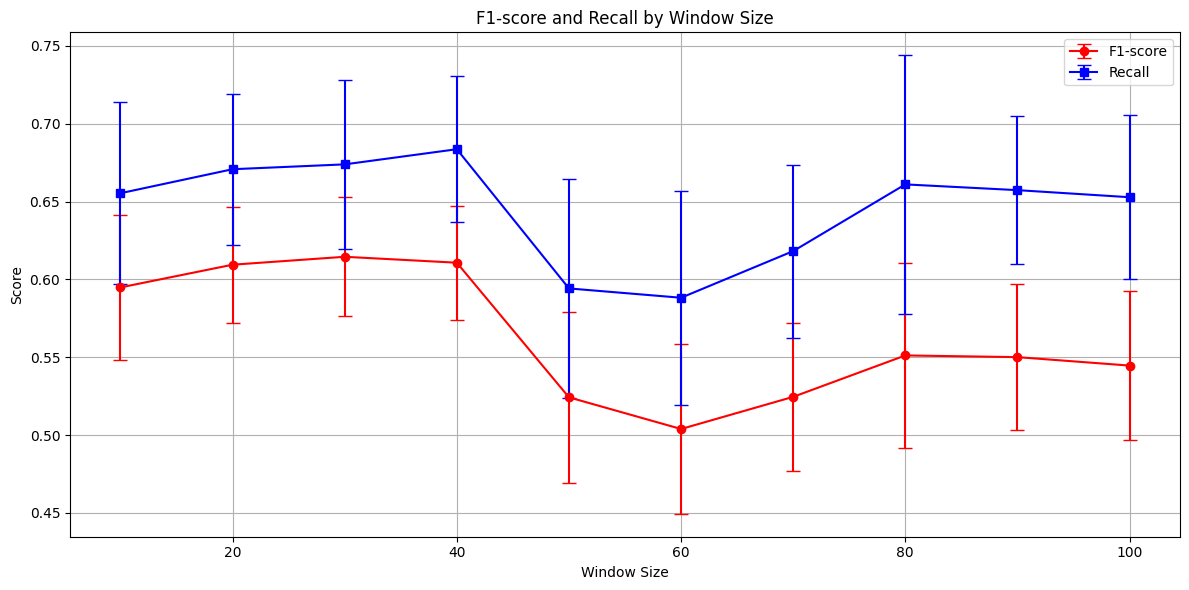

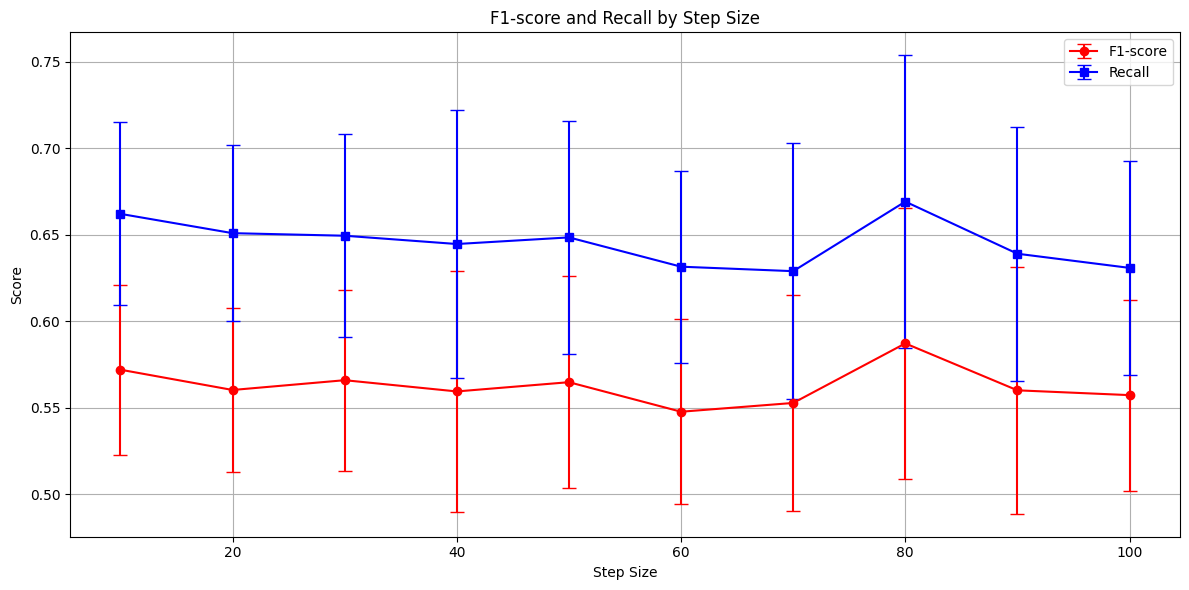

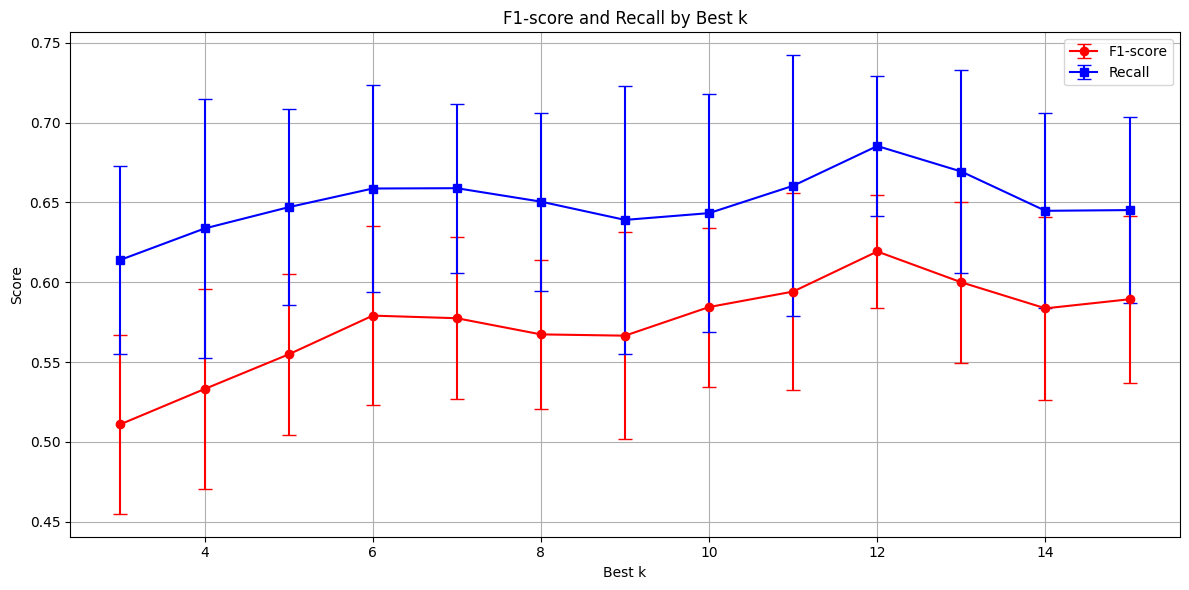

In [76]:
plot_all_summaries(summary_window, summary_step, summary_k)

In [ ]:
# def plot_all_summaries(summary_window, summary_step, summary_k):
#     """
#     Plots bar charts with error bars showing the mean and standard deviation of F1-scores and Recall for different hyperparameters: window size, step size, and best_k (number of selected features).

#     Args:
#         summary_window (pd.DataFrame): DataFrame summarizing results grouped by window size.
#         summary_step (pd.DataFrame): DataFrame summarizing results grouped by step size.
#         summary_k (pd.DataFrame): DataFrame summarizing results grouped by number of selected features (k).

#     Returns:
#         None. Displays six bar plots with error bars:
#             1. Mean F1-score by Window Size
#             2. Mean Recall by Window Size
#             3. Mean F1-score by Step Size
#             4. Mean Recall by Step Size
#             5. Mean F1-score by Best k
#             6. Mean Recall by Best k
#     """
#     # Flatten column names if using MultiIndex
#     summary_window.columns = ['_'.join(col).strip('_') for col in summary_window.columns.values]
#     summary_step.columns = ['_'.join(col).strip('_') for col in summary_step.columns.values]
#     summary_k.columns = ['_'.join(col).strip('_') for col in summary_k.columns.values]

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Window', y='F1_mean', data=summary_window, palette='viridis', ci=None)
#     plt.errorbar(x=range(len(summary_window)), y=summary_window['F1_mean'], yerr=summary_window['F1_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean F1-score by Window Size')
#     plt.xlabel('Window Size')
#     plt.ylabel('Mean F1-score')
#     plt.grid(True, axis='y')
#     plt.tight_layout()

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Window', y='Recall_mean', data=summary_window, palette='coolwarm', ci=None)
#     plt.errorbar(x=range(len(summary_window)), y=summary_window['Recall_mean'], yerr=summary_window['Recall_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean Recall by Window Size')
#     plt.xlabel('Window Size')
#     plt.ylabel('Mean Recall')
#     plt.grid(True, axis='y')
#     plt.tight_layout()

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Step', y='F1_mean', data=summary_step, palette='magma', ci=None)
#     plt.errorbar(x=range(len(summary_step)), y=summary_step['F1_mean'], yerr=summary_step['F1_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean F1-score by Step Size')
#     plt.xlabel('Step Size')
#     plt.ylabel('Mean F1-score')
#     plt.grid(True, axis='y')
#     plt.tight_layout()

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Step', y='Recall_mean', data=summary_step, palette='flare', ci=None)
#     plt.errorbar(x=range(len(summary_step)), y=summary_step['Recall_mean'], yerr=summary_step['Recall_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean Recall by Step Size')
#     plt.xlabel('Step Size')
#     plt.ylabel('Mean Recall')
#     plt.grid(True, axis='y')
#     plt.tight_layout()

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Best_k', y='F1_mean', data=summary_k, palette='cubehelix', ci=None)
#     plt.errorbar(x=range(len(summary_k)), y=summary_k['F1_mean'], yerr=summary_k['F1_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean F1-score by Best k')
#     plt.xlabel('Best k')
#     plt.ylabel('Mean F1-score')
#     plt.grid(True, axis='y')
#     plt.tight_layout()

#     plt.figure(figsize=(18, 6))
#     sns.barplot(x='Best_k', y='Recall_mean', data=summary_k, palette='crest', ci=None)
#     plt.errorbar(x=range(len(summary_k)), y=summary_k['Recall_mean'], yerr=summary_k['Recall_std'], fmt='none', c='black', capsize=5)
#     plt.title('Mean Recall by Best k')
#     plt.xlabel('Best k')
#     plt.ylabel('Mean Recall')
#     plt.grid(True, axis='y')
#     plt.tight_layout()


/tmp/ipython-input-62-1817220769.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Window', y='F1_mean', data=summary_window, palette='viridis', ci=None)
/tmp/ipython-input-62-1817220769.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Window', y='F1_mean', data=summary_window, palette='viridis', ci=None)
/tmp/ipython-input-62-1817220769.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Window', y='Recall_mean', data=summary_window, palette='coolwarm', ci=None)
/tmp/ipython-input-62-1817220769.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Wi

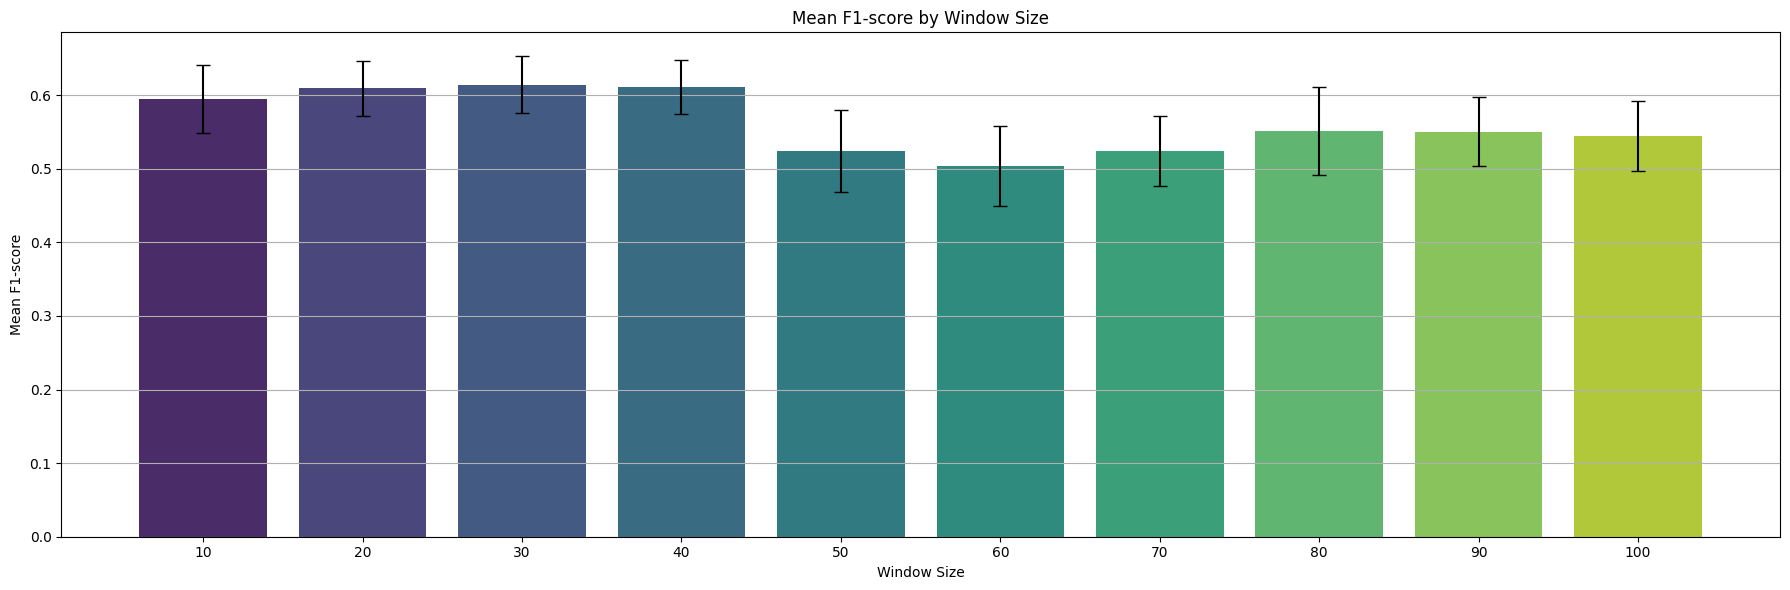

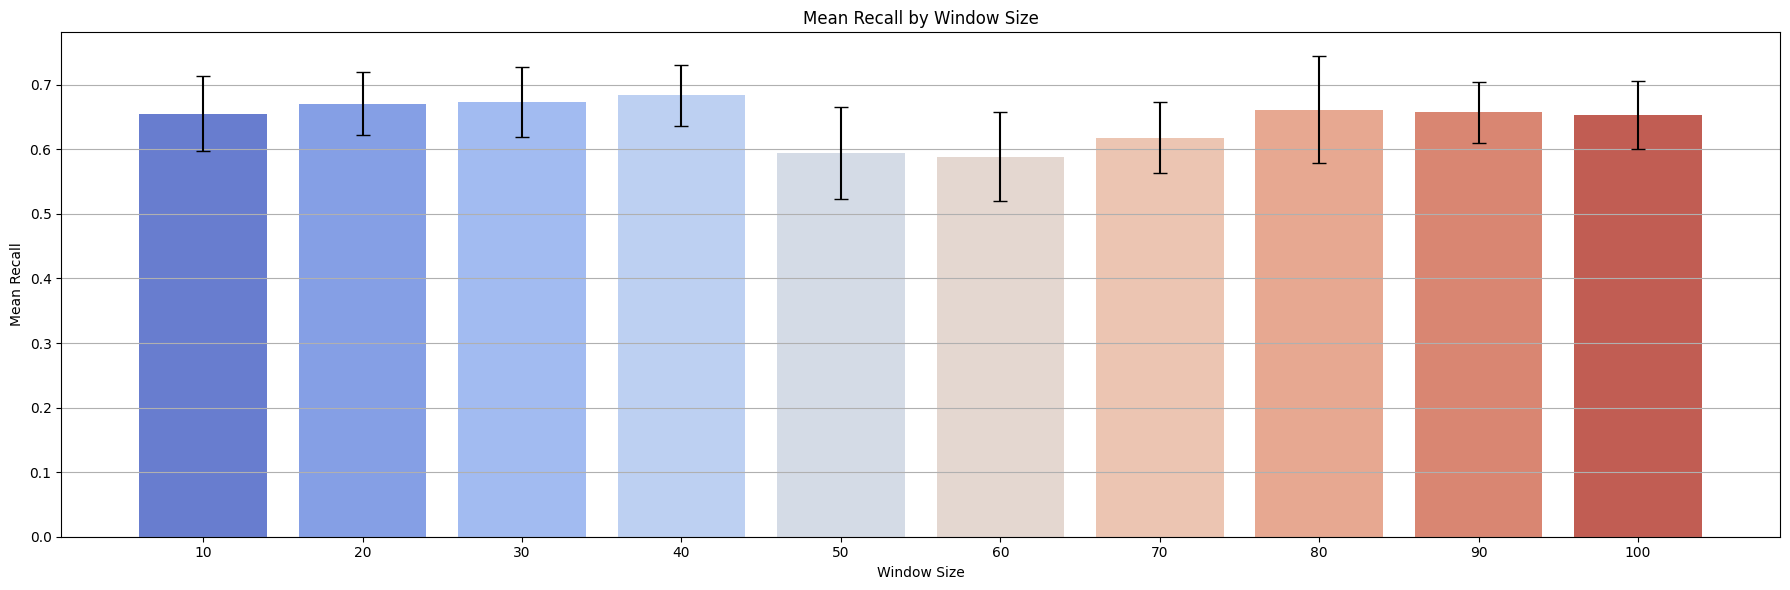

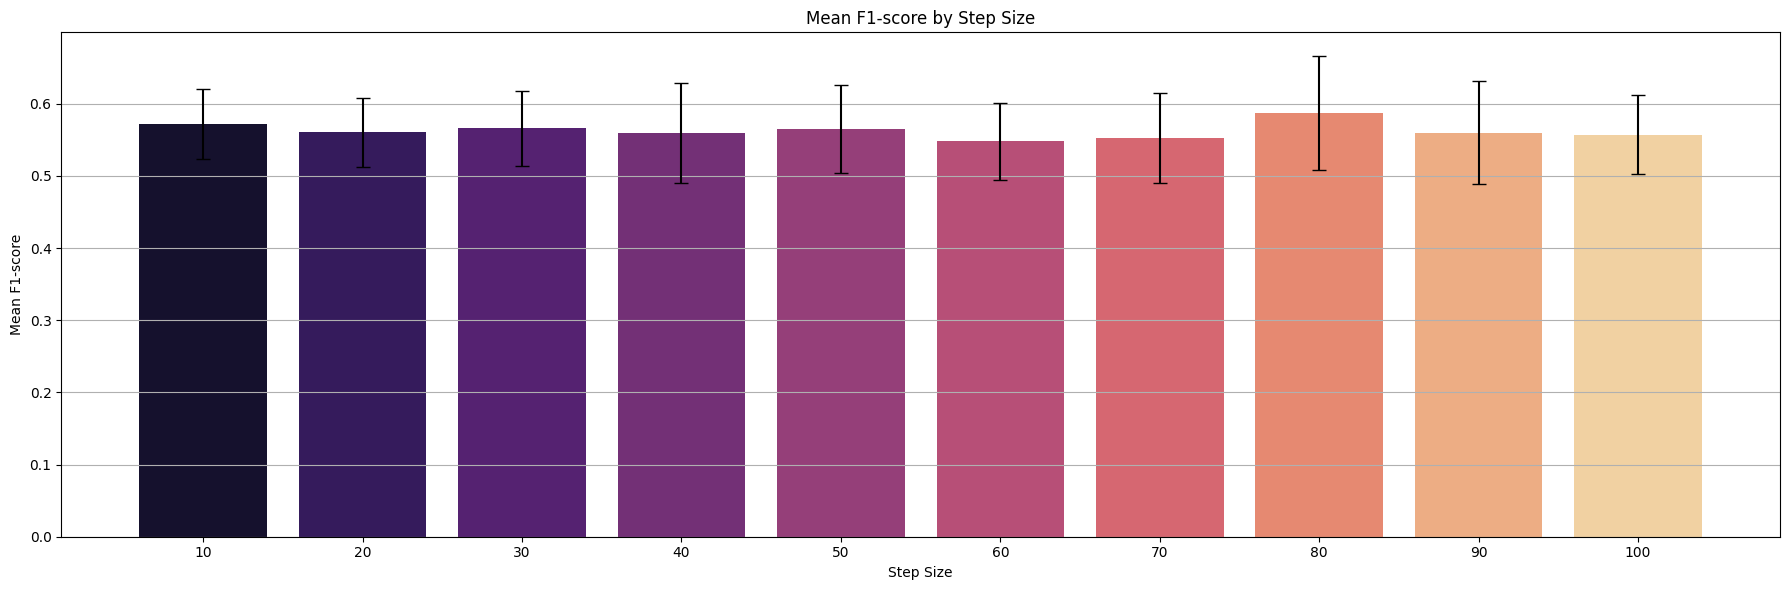

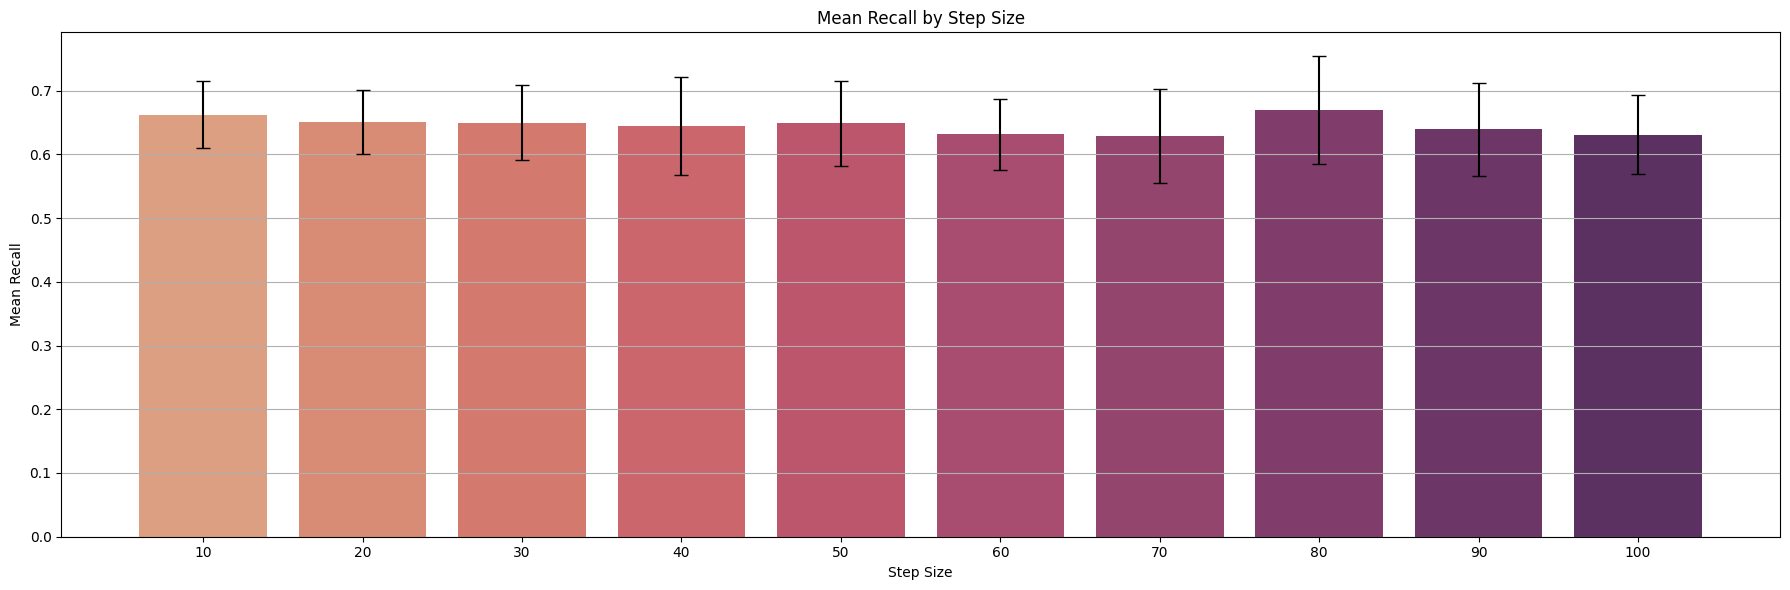

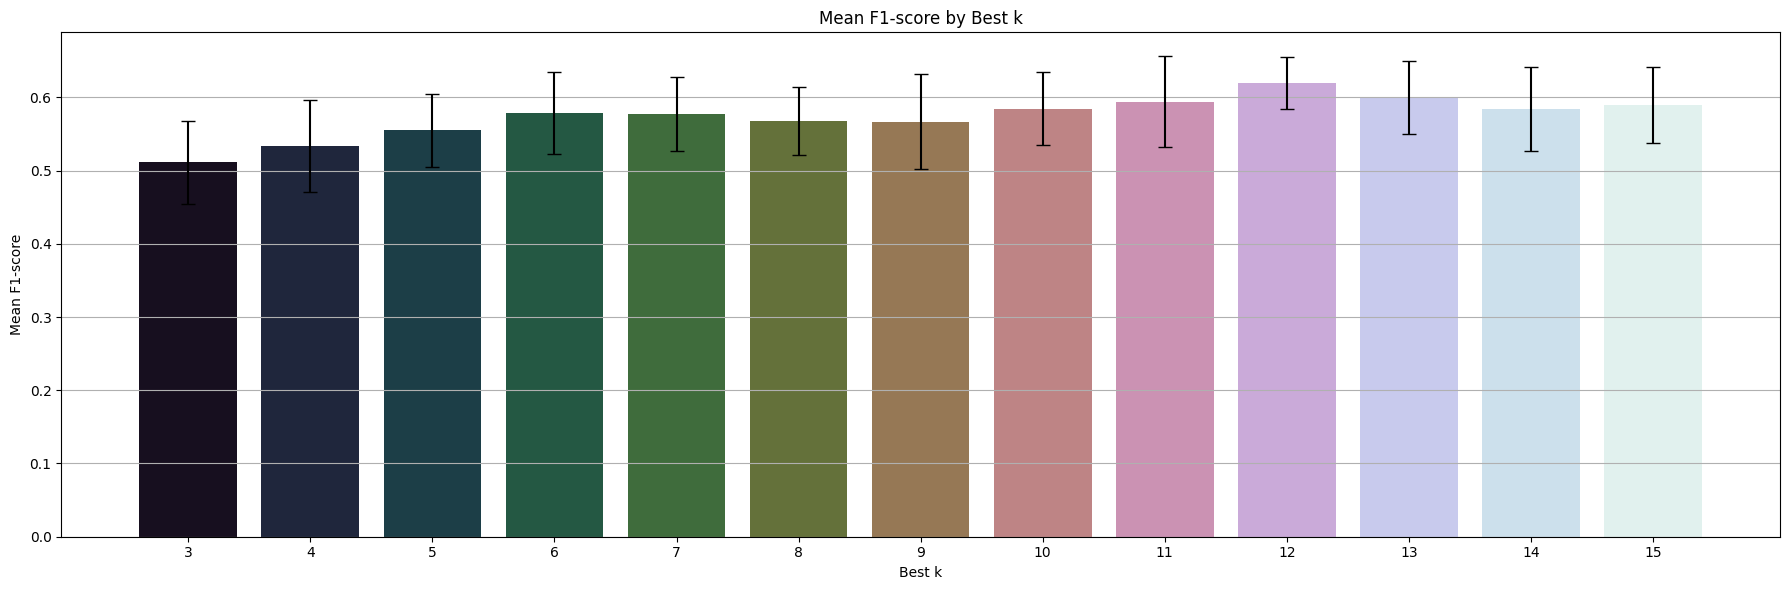

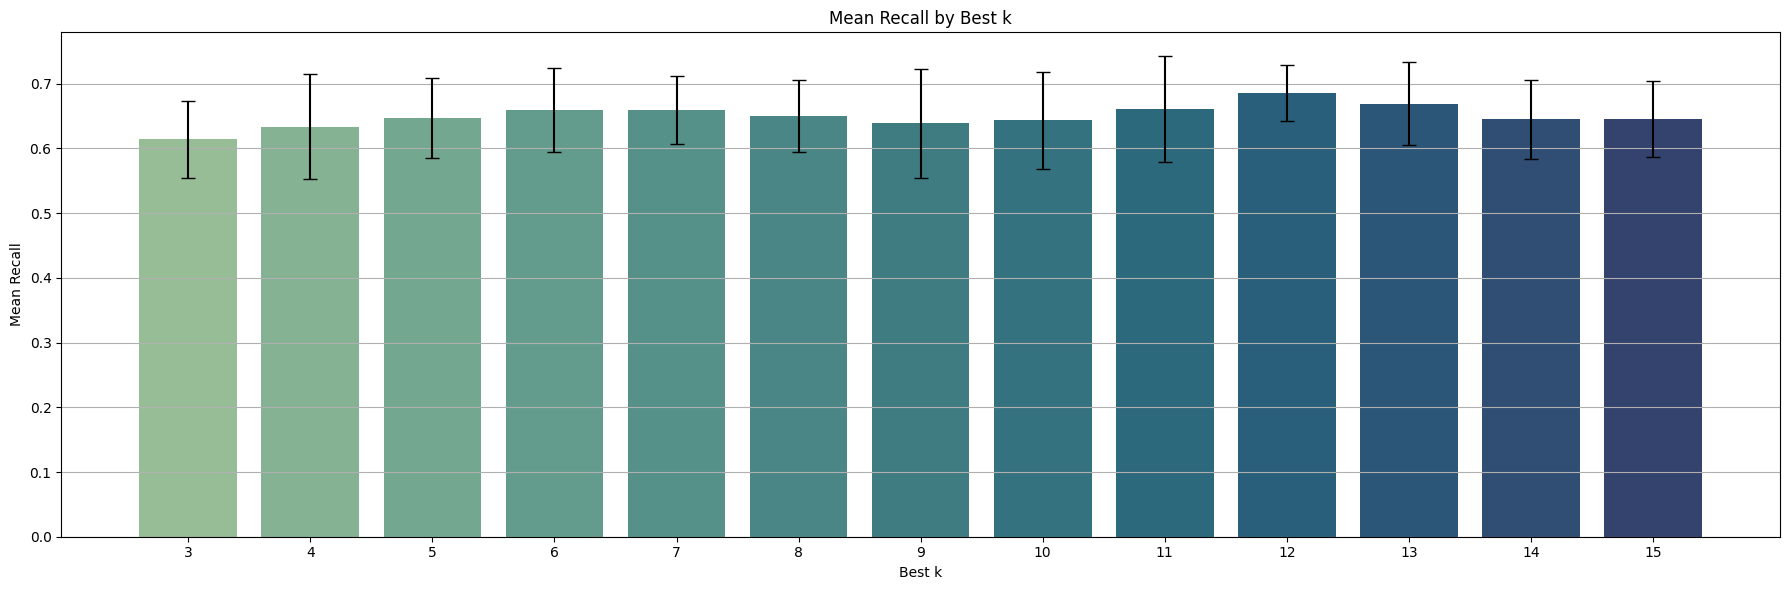

In [ ]:
plot_all_summaries(summary_window, summary_step, summary_k)

In [ ]:
summary_window.sort_values(by="F1_mean", ascending=False).reset_index()

,index,Window,F1_mean,F1_std,F1_count,Recall_mean,Recall_std
0,2,30,0.614506,0.038265,60,0.673877,0.054089
1,3,40,0.610701,0.036541,60,0.683615,0.046907
2,1,20,0.609423,0.037232,60,0.670766,0.048498
3,0,10,0.594819,0.046735,60,0.655349,0.058485
4,7,80,0.551128,0.059588,60,0.661012,0.082960
5,8,90,0.550042,0.046912,60,0.657319,0.047538
6,9,100,0.544612,0.047699,60,0.652776,0.052525
7,6,70,0.524525,0.047462,60,0.618150,0.055600
8,4,50,0.524215,0.055097,60,0.594176,0.070616
9,5,60,0.503871,0.054474,60,0.588194,0.068834


In [ ]:
summary_step.sort_values(by="F1_mean", ascending=False).reset_index()

,index,Step,F1_mean,F1_std,F1_count,Recall_mean,Recall_std
0,7,80,0.587227,0.078475,60,0.669171,0.084571
1,0,10,0.572032,0.049073,60,0.662084,0.052886
2,2,30,0.565966,0.052351,60,0.649450,0.058711
3,4,50,0.564814,0.061083,60,0.648485,0.067146
4,1,20,0.560313,0.047506,60,0.650934,0.050660
5,8,90,0.560115,0.071351,60,0.639049,0.073481
6,3,40,0.559472,0.069678,60,0.644664,0.077224
7,9,100,0.557342,0.055228,60,0.630864,0.061925
8,6,70,0.552816,0.062410,60,0.628974,0.074040
9,5,60,0.547745,0.053410,60,0.631558,0.055570


In [ ]:
summary_k.sort_values(by="F1_mean", ascending=False).reset_index()

,index,Best_k,F1_mean,F1_std,F1_count,Recall_mean,Recall_std
0,9,12,0.619300,0.035539,18,0.685386,0.043712
1,10,13,0.599983,0.050320,24,0.669383,0.063693
2,8,11,0.594203,0.061805,28,0.660488,0.081755
3,12,15,0.589381,0.052311,52,0.645241,0.058295
4,7,10,0.584501,0.049815,19,0.643339,0.074401
5,11,14,0.583673,0.057390,34,0.644785,0.060974
6,3,6,0.579120,0.056044,68,0.658758,0.064835
7,4,7,0.577494,0.050865,41,0.658958,0.052911
8,5,8,0.567363,0.046740,35,0.650537,0.055833
9,6,9,0.566567,0.064802,16,0.639095,0.084105


Only for last 14 sheets results

In [ ]:
results_df.shape

(600, 12)

In [ ]:
results_df.to_csv("All_Param.csv")

In [ ]:
results_df = pd.read_csv("All_Param.csv")

**Training for 40 sheets**

In [ ]:
def evaluate_smote_model_with_selection(df_all, n_splits=3):
    """
    Evaluate classification models with selected features using GroupKFold cross-validation
    and SMOTE for class imbalance handling.

    Args:
        df_all (pd.DataFrame): A DataFrame containing model configurations.
            Must include the following columns:
            - 'Window': the window size used for feature extraction.
            - 'Step': the step size used for feature extraction.
            - 'SelectedFeatures': a comma-separated string of selected feature names.
            - 'Model': the name of the classifier to be used (must match keys in `models` dictionary).
        n_splits (int, optional): Number of folds for GroupKFold cross-validation. Default is 3.

    Returns:
        pd.DataFrame: A DataFrame summarizing the average performance metrics
            (Accuracy, Recall, Precision, F1, ROC_AUC) for each configuration.
    """
    comparison_results = []

    for i in tqdm(range(df_all.shape[0]), desc="Evaluating Models with CV"):
        window_size = df_all["Window"][i]
        step_size = df_all["Step"][i]
        df_default = unify_dataset_length(xls.sheet_names, window_size, step_size)

        keep_features_columns = [j.strip() for j in df_all["SelectedFeatures"][i].split(",")]
        keep_columns = keep_features_columns + ['Subject', 'Label', 'Gender']
        df_filter = df_default[keep_columns]

        model_name = df_all["Model"].iloc[i]
        model = models[model_name]

        X = df_filter[keep_features_columns].values
        y = df_filter['Label'].values
        groups = df_filter['Subject'].values

        gkf = GroupKFold(n_splits=n_splits)
        fold_metrics = []

        for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Apply SMOTE only to training data
            smote = SMOTE(random_state=42)
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

            # Feature scaling
            scaler = StandardScaler()
            X_train_res = scaler.fit_transform(X_train_res)
            X_test = scaler.transform(X_test)

            # Fit model
            model.fit(X_train_res, y_train_res)
            y_pred = model.predict(X_test)

            try:
                y_proba = model.predict_proba(X_test)[:, 1]
                roc_auc = roc_auc_score(y_test, y_proba)
            except:
                # If the model does not support predict_proba, or predicts a single category, set to nan
                y_proba = np.zeros_like(y_pred)
                roc_auc = float('nan')

            # Collect metrics for this fold
            fold_metrics.append({
                'Accuracy': accuracy_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred, zero_division=0),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'F1': f1_score(y_test, y_pred, zero_division=0),
                'ROC_AUC': roc_auc
            })

        # Average metrics across folds
        avg_result = {
            'Model': model_name,
            'Window': window_size,
            'Step': step_size,
            'Recall': np.mean([m['Recall'] for m in fold_metrics]),
            'F1': np.mean([m['F1'] for m in fold_metrics]),
            'Precision': np.mean([m['Precision'] for m in fold_metrics]),
            'ROC_AUC': np.nanmean([m['ROC_AUC'] for m in fold_metrics]),
            'Accuracy': np.mean([m['Accuracy'] for m in fold_metrics])
        }

        comparison_results.append(avg_result)

    return pd.DataFrame(comparison_results)

In [ ]:
# Substituting the data of 40 people into results_df in the first 5 rows "recall" the best performing parameter.
results_df_5 = results_df.sort_values('Recall', ascending=False).head(5)
results_df_5.reset_index(inplace=True)
evaluate_smote_model_with_selection(results_df_5)

Evaluating Models with CV: 100%|██████████| 5/5 [01:42<00:00, 20.45s/it]


,Model,Window,Step,Recall,F1,Precision,ROC_AUC,Accuracy
0,SVC,30,80,0.402778,0.322575,0.270513,0.624860,0.713828
1,DecisionTree,80,10,0.132026,0.153560,0.314092,0.528402,0.783495
2,DecisionTree,80,40,0.138889,0.162672,0.222854,0.526056,0.776640
3,DecisionTree,80,20,0.151163,0.147861,0.145338,0.529070,0.770849
4,RandomForest,10,80,0.245370,0.262570,0.290618,0.586841,0.778541


In [ ]:
filtered_results_df = results_df[
    (results_df['Window'].isin([10, 20, 30, 40])) &
    (results_df['Step'].isin([10, 20, 30, 50, 80, 90])) &
    (results_df['Best_k'].isin([11, 12, 13, 15]))
]
filtered_results_df.reset_index(inplace=True)

In [ ]:
filtered_results_df.to_csv("Filter_All_Param.csv")

In [ ]:
# Substitute the data for 40 people into filtered results_df all parameters
df_all_results = evaluate_smote_model_with_selection(filtered_results_df)

Evaluating Models with CV: 100%|██████████| 47/47 [17:08<00:00, 21.88s/it]


In [ ]:
df_all_results.to_csv("Filter_All_Param_Modelling_Result.csv", index=False)

In [ ]:
df_all_results = pd.read_csv("Filter_All_Param_Modelling_Result.csv")

In [ ]:
df_all_results_sort_f1 = df_all_results.sort_values(by="F1", ascending=False)[:5]

In [ ]:
df_all_results_sort_recall = df_all_results.sort_values(by="Recall", ascending=False)[:5]

In [ ]:
df_filter_result = pd.concat([df_all_results_sort_f1, df_all_results_sort_recall])
df_filter_result = df_filter_result.drop_duplicates(subset=["Model", "Window", "Step"])
df_filter_result

,Model,Window,Step,Recall,F1,Precision,ROC_AUC,Accuracy
34,LogisticRegression,30,80,0.587963,0.406629,0.320855,0.817656,0.735653
36,KNN,30,80,0.421296,0.388234,0.360280,0.682730,0.777930
0,LogisticRegression,10,10,0.618357,0.387217,0.282244,0.702388,0.664138
45,RandomForest,40,80,0.310185,0.381079,0.500516,0.656127,0.828907
10,LogisticRegression,20,10,0.581807,0.376730,0.279142,0.706019,0.671497
2,LogisticRegression,10,20,0.576087,0.371692,0.278369,0.687487,0.663322
6,LogisticRegression,10,50,0.573099,0.363977,0.266830,0.677075,0.653846


In [ ]:
# In order not to duplicate the results of the modelling of the 40 sheets that follow
results_df = results_df.drop(["Recall", "F1", "Precision", "ROC_AUC"],axis=1)

In [ ]:
df_filter_result = pd.merge(df_filter_result, results_df, on=["Model", "Window", "Step"], how="left")

df_filter_result

,Model,Window,Step,Recall,F1,Precision,ROC_AUC,Accuracy_x,Unnamed: 0,Accuracy_y,SelectedFeatures,FeatureSelectionMethod,FeatureScores,Best_k
0,LogisticRegression,30,80,0.587963,0.406629,0.320855,0.817656,0.735653,162,0.698611,"HHb_std, O2Hb_max, tHb_max, tHb_min, tHb_media...",random_forest,"[('HHb_std', np.float64(0.11690638380078712)),...",15
1,KNN,30,80,0.421296,0.388234,0.360280,0.682730,0.777930,165,0.666667,"HHb_std, O2Hb_max, tHb_max, tHb_min, tHb_media...",random_forest,"[('HHb_std', np.float64(0.11690638380078712)),...",12
2,LogisticRegression,10,10,0.618357,0.387217,0.282244,0.702388,0.664138,0,0.573913,"O2Hb_max, HHb_max, O2Hb_mean, O2Hb_median, HHb...",random_forest,"[('O2Hb_max', np.float64(0.12255953399129209))...",15
3,RandomForest,40,80,0.310185,0.381079,0.500516,0.656127,0.828907,224,0.620833,"tHb_max, tHb_mean, tHb_median, tHb_min, O2Hb_m...",select_k_best,"[('tHb_max', np.float64(52.79816034065594)), (...",15
4,LogisticRegression,20,10,0.581807,0.376730,0.279142,0.706019,0.671497,60,0.565385,"O2Hb_max, HHb_max, O2Hb_median, O2Hb_mean, O2H...",random_forest,"[('O2Hb_max', np.float64(0.14393235274917274))...",15
5,LogisticRegression,10,20,0.576087,0.371692,0.278369,0.687487,0.663322,6,0.494928,"O2Hb_median, O2Hb_max, O2Hb_mean, HHb_max, HHb...",random_forest,"[('O2Hb_median', np.float64(0.1053020220291485...",15
6,LogisticRegression,10,50,0.573099,0.363977,0.266830,0.677075,0.653846,24,0.565789,"O2Hb_max, O2Hb_median, HHb_max, O2Hb_mean, HHb...",random_forest,"[('O2Hb_max', np.float64(0.11209992487915182))...",15


In [ ]:
def unify_dataset_length_for_optimize_model(window_size, step_size, df_filter_result, sheet_name = xls.sheet_names):
    """
    Unifies the dataset length across all subjects using specified window and step sizes, reorders and filters columns based on selected features, and optionally prepares the dataset for saving and downstream model optimization.

    Args:
        window_size (int): The size of the sliding window used for feature extraction.
        step_size (int): The step size for moving the sliding window.
        df_filter_result (pd.DataFrame): A DataFrame containing at least a "SelectedFeatures" column with a comma-separated string of feature names.
        sheet_name (list[str], optional): A list of sheet names to process from the Excel file. Defaults to all sheets in `xls`.

    Returns:
        pd.DataFrame: A filtered and reordered DataFrame that includes:
            - The columns 'Subject', 'Label', 'Gender'
            - The selected feature columns specified in `df_filter_result`
    """
    df = unify_dataset_length(sheet_name, window_size, step_size)

    # Reorder columns: move last three columns ('Subject', 'Label', 'Gender') to the front
    cols = df.columns.tolist()
    new_cols = cols[-3:] + cols[:-3]
    df = df[new_cols]

    default_list = ['Subject', 'Label', 'Gender']
    feature_list = default_list + [s.strip() for s in df_filter_result["SelectedFeatures"].iloc[0].split(',')]
    df = df[feature_list]

    print(df.head())
    print(f"This shape: {df.shape}")
    print(f"Each person has {df['Subject'].value_counts().values[0]} data.")
    print(df["Label"].value_counts())

    return df


## Optimize models

In [ ]:
def train_and_evaluate_model(model_name, df, model, param_grid, window, step, n_splits=3):
    """
    Train and evaluate a classification model using GroupKFold cross-validation,
    SMOTE for handling class imbalance, and standardized features.

    Args:
        model_name (str): The name of the classification model.
        df (pd.DataFrame): The input dataset, must contain 'Label' and 'Subject' columns.
        model (sklearn classifier): A scikit-learn compatible classification model.
        param_grid (dict): A dictionary specifying hyperparameter combinations to evaluate.
        window (int): The size of the sliding window used to generate features.
        step (int): The step size of the sliding window.
        n_splits (int, optional): Number of folds for GroupKFold cross-validation. Default is 3.

    Returns:
        top5_params_df (pd.DataFrame): DataFrame containing the top 5 hyperparameter
            combinations sorted by average F1-score, along with associated metrics.
        final_y_test (np.ndarray or pd.Series): True labels from the test fold of the best model.
        final_y_pred (np.ndarray): Predicted labels from the test fold of the best model.
        final_y_proba (np.ndarray): Predicted probabilities from the test fold of the best model.
    """
    X = df.drop(["Label", "Subject"], axis=1)
    y = df['Label']
    groups = df['Subject']

    all_results = []

    gkf = GroupKFold(n_splits=n_splits)

    for params in ParameterGrid(param_grid):
        fold_metrics = []

        for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
            X_train_raw, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_test_raw, y_test = X.iloc[test_idx], y.iloc[test_idx]

            smote = SMOTE(random_state=42)
            X_resampled_raw, y_resampled = smote.fit_resample(X_train_raw, y_train)

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_resampled_raw)
            X_test = scaler.transform(X_test_raw)

            model.set_params(**params)
            model.fit(X_train, y_resampled)

            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            fold_metrics.append({
                "Accuracy": accuracy_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "F1-score": f1_score(y_test, y_pred),
                "ROC_AUC": roc_auc_score(y_test, y_proba),
                "y_test": y_test,
                "y_pred": y_pred,
                "y_proba": y_proba
            })

        # of results per discount averaged
        avg_result = {
            "Model": model_name,
            "Window": window,
            "Step": step,
            "params": params,
            "Accuracy": np.mean([m["Accuracy"] for m in fold_metrics]),
            "Recall": np.mean([m["Recall"] for m in fold_metrics]),
            "Precision": np.mean([m["Precision"] for m in fold_metrics]),
            "F1-score": np.mean([m["F1-score"] for m in fold_metrics]),
            "ROC_AUC": np.mean([m["ROC_AUC"] for m in fold_metrics]),
            "last_y_test": fold_metrics[-1]["y_test"],
            "last_y_pred": fold_metrics[-1]["y_pred"],
            "last_y_proba": fold_metrics[-1]["y_proba"]
        }

        all_results.append(avg_result)

    top5 = sorted(all_results, key=lambda x: x["F1-score"], reverse=True)[:5]
    top5_params_df = pd.DataFrame([{k: v for k, v in r.items() if not k.startswith("last_")} for r in top5])

    best_model = top5[0]

    return top5_params_df, best_model["last_y_test"], best_model["last_y_pred"], best_model["last_y_proba"]


In [ ]:
Optimized_models_results_df = pd.DataFrame()

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [10, 20, 30, 40, 50],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', None]
}

In [ ]:
knn_model = KNeighborsClassifier()

param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan', 'minkowski'],
    "p": [1, 2]  # p=1: Manhattan, p=2: Euclidean
}


In [ ]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

param_grid_lr = [
    {
        "penalty": ['l1'],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ['liblinear', 'saga']
    },
    {
        "penalty": ['l2'],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ['liblinear', 'lbfgs', 'saga']
    },
    {
        "penalty": ['elasticnet'],
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ['saga'],
        "l1_ratio": [0.0, 0.5, 1.0]
    },
    {
        "penalty": [None],
        "solver": ['lbfgs']
    }
]


### window_size=30, step=80 (LR & KNN)

In [ ]:
df_3080 = unify_dataset_length_for_optimize_model(window_size=30, step_size=80,df_filter_result=df_filter_result, sheet_name=xls.sheet_names)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  0.346397  0.573559  1.510213  0.947385    1.183154   
1        1      0       0  0.928890  0.572678  4.248937  3.386006    3.789117   
2        1      0       0  1.085548 -1.792213  3.834065  3.328992    3.584611   
3        1      0       0  0.903613 -0.401615  6.015881  4.297490    4.452760   
4        1      0       0  0.878283 -0.585766  6.510037  4.563634    4.622956   

   O2Hb_median  tHb_mean  O2Hb_mean   HHb_max  O2Hb_min  HHb_median  O2Hb_std  \
0     0.323704  1.166384   0.133626  1.948666 -0.680656    0.924711  0.370890   
1    -0.753838  3.731003  -0.882374  6.524301 -2.510021    4.490982  0.855091   
2    -2.979013  3.555375  -3.106001  8.770542 -4.936573    6.606265  1.040695   
3    -2.829760  4.628061  -2.718866  9.159389 -4.458740    7.187537  1.168352   
4    -3.283815  4.951975  -3.095682  9.840988 -4.788673    7.867994  1.278313   

   HHb_mean   HHb_min   tH

In [ ]:
lr_3080_df, lr_3080_ytest, lr_3080_ypred, lr_3080_yproba = train_and_evaluate_model(
    "LogisticRegression", df_3080, lr_model, param_grid_lr, window=30, step=80
)

In [ ]:
pd.set_option('display.max_rows', None)     # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', None)        # 不限制显示宽度
pd.set_option('display.max_colwidth', None) # 显示所有列内容

In [ ]:
lr_3080_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.919719,0.925926,0.707946,0.796481,0.961560
1,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.917582,0.912037,0.704678,0.789423,0.961455
2,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841
3,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841
4,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.960683


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, lr_3080_df])

In [ ]:
knn_3080_df, knn_3080_ytest, knn_3080_ypred, knn_3080_yproba = train_and_evaluate_model(
    "KNN", df_3080, knn_model, param_grid_knn, window=30, step=80
)

In [ ]:
knn_3080_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,KNN,30,80,"{'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",0.831502,0.62037,0.469973,0.521957,0.768957
1,KNN,30,80,"{'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.831502,0.62037,0.469973,0.521957,0.773990
2,KNN,30,80,"{'metric': 'euclidean', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.831502,0.62037,0.469973,0.521957,0.768957
3,KNN,30,80,"{'metric': 'euclidean', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.831502,0.62037,0.469973,0.521957,0.773990
4,KNN,30,80,"{'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.831502,0.62037,0.469973,0.521957,0.768957


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, knn_3080_df])

### LR

#### window_size=10, step=10

In [ ]:
df_1010 = unify_dataset_length_for_optimize_model(
    window_size=10,
    step_size=10,
    df_filter_result=df_filter_result,
    sheet_name=xls.sheet_names
)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  0.099612  0.573559  1.510213  1.048146    1.089539   
1        1      0       0  0.125263  0.471676  1.240826  1.197282    1.210484   
2        1      0       0  0.240061  0.033733  1.268109  0.947385    1.135819   
3        1      0       0  0.691244 -0.419659  3.706937  1.437707    2.514291   
4        1      0       0  0.245781  0.534138  5.473020  3.909482    4.694947   

   O2Hb_median  tHb_mean  O2Hb_mean   HHb_max  O2Hb_min  HHb_median  O2Hb_std  \
0     0.391315  1.156717   0.410215  0.936554  0.344772    0.697906  0.067127   
1     0.328194  1.215712   0.313816  1.104134  0.095024    0.892663  0.135421   
2    -0.293533  1.126724  -0.323153  1.948666 -0.680656    1.412494  0.259800   
3    -0.734520  2.569252  -0.665360  4.126497 -0.790634    3.254285  0.143615   
4     0.071562  4.703888   0.099223  4.938780 -0.305393    4.623285  0.277244   

   HHb_mean   HHb_min   tH

In [ ]:
lr_1010_df, lr_1010_ytest, lr_1010_ypred, lr_1010_yproba = train_and_evaluate_model(
    "LogisticRegression", df_1010, lr_model, param_grid_lr, window=10, step=10
)

In [ ]:
lr_1010_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.858775,0.915459,0.553232,0.687564,0.918131
1,LogisticRegression,10,10,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.857402,0.915459,0.550568,0.685474,0.917862
2,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.857660,0.913647,0.551268,0.685362,0.917769
3,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.857123,0.914251,0.549906,0.684712,0.918933
4,LogisticRegression,10,10,"{'C': 100, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}",0.857123,0.914251,0.549906,0.684712,0.918933


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, lr_1010_df])

#### window_size=20, step=10

In [ ]:
df_2010 = unify_dataset_length_for_optimize_model(
    window_size=20,
    step_size=10,
    df_filter_result=df_filter_result,
    sheet_name=xls.sheet_names
)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  0.135968  0.573559  1.510213  1.048146    1.200089   
1        1      0       0  0.337272  0.471676  1.268109  0.947385    1.198270   
2        1      0       0  1.044924  0.033733  3.706937  0.947385    1.352908   
3        1      0       0  0.865395  0.534138  5.473020  1.437707    3.808209   
4        1      0       0  0.296963  1.324104  6.410550  3.909482    5.535890   

   O2Hb_median  tHb_mean  O2Hb_mean   HHb_max  O2Hb_min  HHb_median  O2Hb_std  \
0     0.382330  1.186215   0.362015  1.104134  0.095024    0.808291  0.115181   
1     0.064379  1.171218  -0.004668  1.948666 -0.680656    1.131759  0.383965   
2    -0.556206  1.847988  -0.494256  4.126497 -0.790634    2.066998  0.269368   
3    -0.362526  3.636570  -0.283068  4.938780 -0.790634    4.170637  0.447234   
4     0.573259  5.379371   0.538564  5.116472 -0.305393    4.962529  0.520223   

   HHb_mean   HHb_min   tH

In [ ]:
lr_2010_df, lr_2010_ytest, lr_2010_ypred, lr_2010_yproba = train_and_evaluate_model(
    "LogisticRegression", df_2010, lr_model, param_grid_lr, window=20, step=10
)

In [ ]:
lr_2010_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,20,10,"{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}",0.862980,0.876068,0.567333,0.685102,0.922521
1,LogisticRegression,20,10,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.861832,0.880952,0.564842,0.684356,0.920420
2,LogisticRegression,20,10,"{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.861007,0.879121,0.563139,0.682548,0.920788
3,LogisticRegression,20,10,"{'penalty': None, 'solver': 'lbfgs'}",0.861571,0.874237,0.564998,0.682393,0.922097
4,LogisticRegression,20,10,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.860745,0.876679,0.563030,0.681589,0.920951


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, lr_2010_df])

#### window_size=10, step=20

In [ ]:
df_1020 = unify_dataset_length_for_optimize_model(
    window_size=10,
    step_size=20,
    df_filter_result=df_filter_result,
    sheet_name=xls.sheet_names
)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  0.099612  0.573559  1.510213  1.048146    1.089539   
1        1      0       0  0.240061  0.033733  1.268109  0.947385    1.135819   
2        1      0       0  0.245781  0.534138  5.473020  3.909482    4.694947   
3        1      0       0  0.162141  1.925728  6.801641  6.486318    6.695035   
4        1      0       0  0.092529  0.572678  4.248937  3.386006    3.550053   

   O2Hb_median  tHb_mean  O2Hb_mean   HHb_max  O2Hb_min  HHb_median  O2Hb_std  \
0     0.391315  1.156717   0.410215  0.936554  0.344772    0.697906  0.067127   
1    -0.293533  1.126724  -0.323153  1.948666 -0.680656    1.412494  0.259800   
2     0.071562  4.703888   0.099223  4.938780 -0.305393    4.623285  0.277244   
3     1.836206  6.661122   1.764544  5.069200  1.417015    4.938091  0.180373   
4    -0.007990  3.646758   0.014919  3.819582 -0.388703    3.609294  0.324750   

   HHb_mean   HHb_min   tH

In [ ]:
lr_1020_df, lr_1020_ytest, lr_1020_ypred, lr_1020_yproba = train_and_evaluate_model(
    "LogisticRegression", df_1020, lr_model, param_grid_lr, window=10, step=20
)

In [ ]:
lr_1020_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,10,20,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.839306,0.903382,0.517636,0.656433,0.900031
1,LogisticRegression,10,20,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.839306,0.903382,0.517636,0.656433,0.899990
2,LogisticRegression,10,20,"{'C': 1, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}",0.839306,0.903382,0.517636,0.656433,0.899990
3,LogisticRegression,10,20,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.837673,0.903382,0.514865,0.654185,0.899594
4,LogisticRegression,10,20,"{'C': 1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}",0.838270,0.887681,0.515758,0.650752,0.899837


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, lr_1020_df])

#### window_size=10, step=50

In [ ]:
df_1050 = unify_dataset_length_for_optimize_model(
    window_size=10,
    step_size=50,
    df_filter_result=df_filter_result,
    sheet_name=xls.sheet_names
)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  0.099612  0.573559  1.510213  1.048146    1.089539   
1        1      0       0  0.042969  1.324104  6.410550  5.598760    6.098668   
2        1      0       0  0.424316 -1.332081  4.014379  3.732564    3.832082   
3        1      0       0  0.359929  0.276134  6.340199  3.418698    4.541608   
4        1      0       0  0.353837 -0.323334  9.188695  8.400319    8.909371   

   O2Hb_median  tHb_mean  O2Hb_mean    HHb_max  O2Hb_min  HHb_median  \
0     0.391315  1.156717   0.410215   0.936554  0.344772    0.697906   
1     0.994051  6.054854   0.977904   5.116472  0.612381    5.092195   
2    -1.837715  3.838411  -1.882976   6.524301 -2.510021    5.676899   
3    -0.760655  4.673750  -0.738576   6.063965 -1.697353    5.302162   
4    -1.199247  8.885365  -1.189081  10.556919 -2.156700   10.108521   

   O2Hb_std   HHb_mean   HHb_min   tHb_std  
0  0.067127   0.746402  0.665091  0

In [ ]:
lr_1050_df, lr_1050_ytest, lr_1050_ypred, lr_1050_yproba = train_and_evaluate_model(
    "LogisticRegression", df_1050, lr_model, param_grid_lr, window=10, step=50
)

In [ ]:
lr_1050_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,10,50,"{'penalty': None, 'solver': 'lbfgs'}",0.855022,0.874269,0.546798,0.670443,0.914183
1,LogisticRegression,10,50,"{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.852323,0.880117,0.541176,0.667646,0.914897
2,LogisticRegression,10,50,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.852323,0.880117,0.541176,0.667646,0.914715
3,LogisticRegression,10,50,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.853576,0.862573,0.543651,0.664425,0.914827
4,LogisticRegression,10,50,"{'C': 100, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}",0.853576,0.862573,0.543651,0.664425,0.914729


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, lr_1050_df])

### window_size=40, step=80 (RF)

In [ ]:
df_4080 = unify_dataset_length_for_optimize_model(
    window_size=40,
    step_size=80,
    df_filter_result=df_filter_result,
    sheet_name=xls.sheet_names
)

   Subject  Label  Gender   HHb_std  O2Hb_max   tHb_max   tHb_min  tHb_median  \
0        1      0       0  1.063875  0.573559  3.706937  0.947385    1.201566   
1        1      0       0  1.767192  0.572678  6.980786  3.386006    3.826249   
2        1      0       0  1.809958 -1.792213  8.217961  3.328992    3.600125   
3        1      0       0  1.458072 -0.401615  6.439939  4.297490    4.469792   
4        1      0       0  1.366041 -0.585766  8.306615  4.563634    4.854062   

   O2Hb_median  tHb_mean  O2Hb_mean    HHb_max  O2Hb_min  HHb_median  \
0     0.064379  1.517101  -0.066120   4.126497 -0.790634    1.131759   
1    -1.273121  4.203192  -1.283669   8.963303 -2.677834    5.099269   
2    -3.274237  4.235323  -3.294228  10.758083 -4.936573    7.253389   
3    -3.387276  4.889612  -3.150963  10.545475 -4.690445    7.835653   
4    -3.417948  5.445561  -3.245113  10.941433 -4.788673    8.498400   

   O2Hb_std  HHb_mean   HHb_min   tHb_std  
0  0.479388  1.583122  0.665091  0.7

In [ ]:
rf_4080_df, rf_4080_ytest, rf_4080_ypred, rf_4080_yproba = train_and_evaluate_model(
    "RandomForest", df_4080, rf_model, param_grid_rf, window=40, step=80
)

In [ ]:
rf_4080_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,RandomForest,40,80,"{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}",0.879426,0.541667,0.633021,0.545259,0.857481
1,RandomForest,40,80,"{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}",0.879426,0.541667,0.633021,0.545259,0.857481
2,RandomForest,40,80,"{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}",0.879426,0.541667,0.633021,0.545259,0.857481
3,RandomForest,40,80,"{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}",0.879426,0.541667,0.633021,0.545259,0.857481
4,RandomForest,40,80,"{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}",0.879426,0.541667,0.633021,0.545259,0.857481


In [ ]:
Optimized_models_results_df = pd.concat([Optimized_models_results_df, rf_4080_df])

In [ ]:
Optimized_models_results_df.sort_values(by="F1-score", ascending=False, inplace=True)

In [ ]:
Optimized_models_results_df.reset_index(drop=True)

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC,Window_Step
0,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.919719,0.925926,0.707946,0.796481,0.961560,30_80
1,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.917582,0.912037,0.704678,0.789423,0.961455,30_80
2,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841,30_80
3,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841,30_80
4,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.960683,30_80
5,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}",0.858775,0.915459,0.553232,0.687564,0.918131,10_10
6,LogisticRegression,10,10,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.857402,0.915459,0.550568,0.685474,0.917862,10_10
7,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}",0.857660,0.913647,0.551268,0.685362,0.917769,10_10
8,LogisticRegression,20,10,"{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}",0.862980,0.876068,0.567333,0.685102,0.922521,20_10
9,LogisticRegression,10,10,"{'C': 100, 'penalty': 'l1', 'solver': 'saga'}",0.857123,0.914251,0.549906,0.684712,0.918933,10_10


In [ ]:
Optimized_models_results_df.to_csv("Optimized_models_results_df.csv")

In [6]:
Optimized_models_results_df = pd.read_csv("Optimized_models_results_df.csv")

/tmp/ipython-input-89-2332488629.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_rows = grouped.apply(lambda x: x.loc[x['F1-score'].idxmax()]).reset_index(drop=True)
/tmp/ipython-input-89-2332488629.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_rows, x="Model_Combo", y=metric, ax=ax, palette=colors)
/tmp/ipython-input-89-2332488629.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(data=best_rows, x="Model_Combo", y=

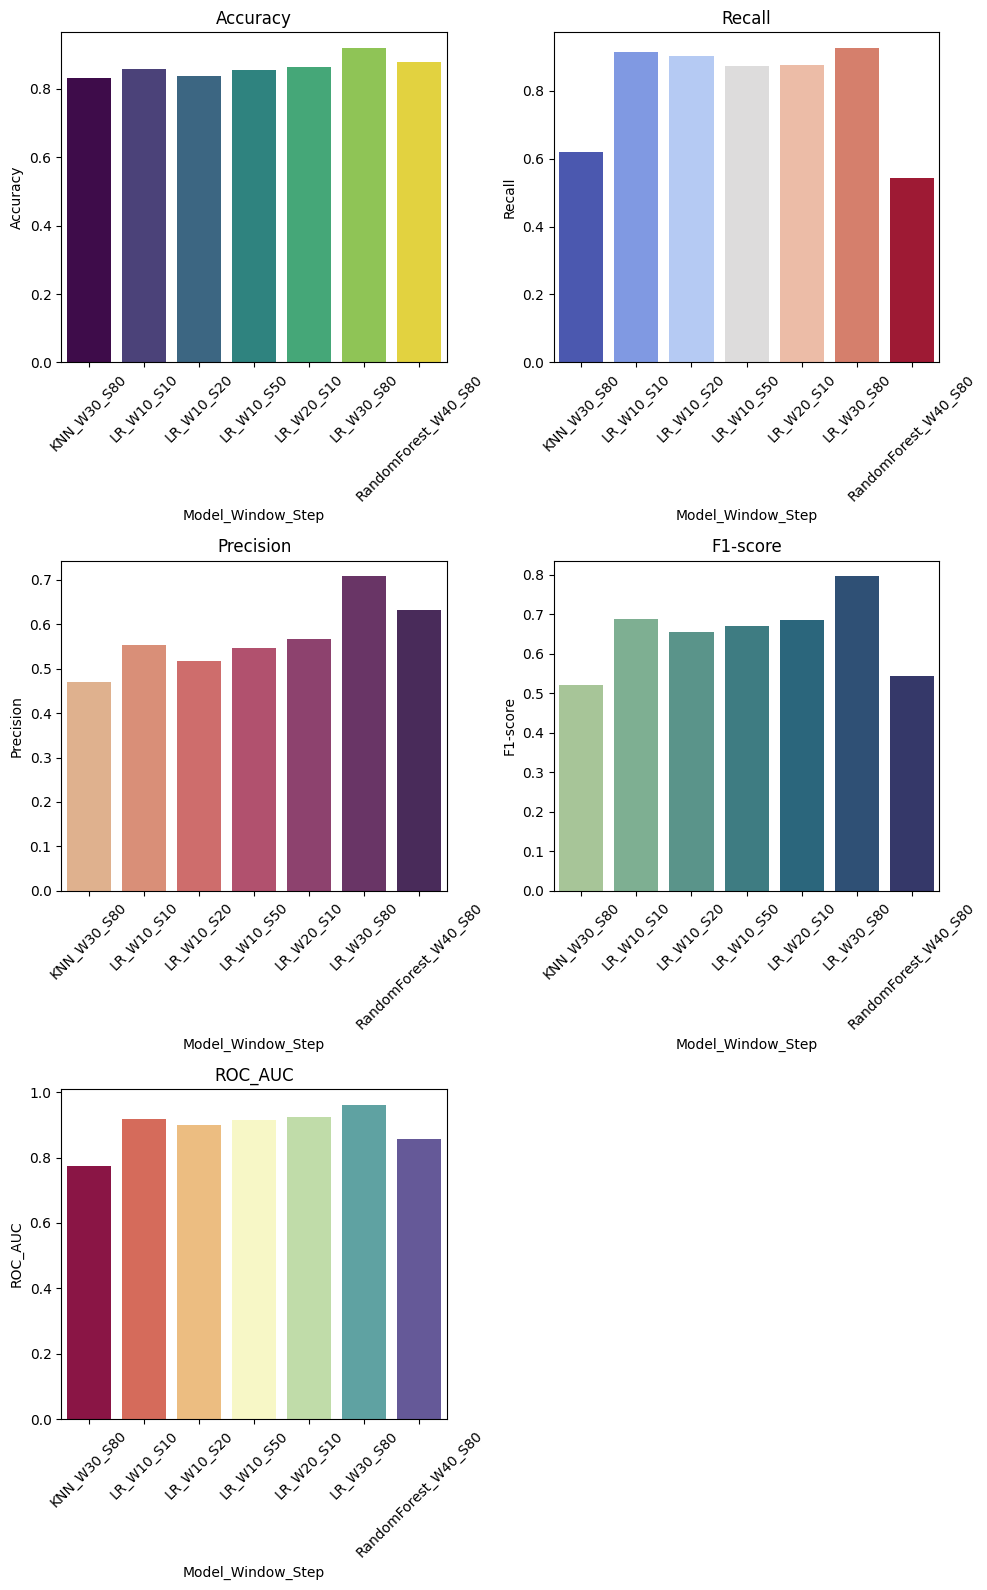

In [89]:
Optimized_models_results_df["Model"] = Optimized_models_results_df["Model"].replace("LogisticRegression", "LR")

Optimized_models_results_df["Model_Combo"] = Optimized_models_results_df["Model"] + "_W" + Optimized_models_results_df["Window"].astype(str) + "_S" + Optimized_models_results_df["Step"].astype(str)

# Select the row with the highest f1-score for each model+window+step combination
grouped = Optimized_models_results_df.groupby("Model_Combo")
best_rows = grouped.apply(lambda x: x.loc[x['F1-score'].idxmax()]).reset_index(drop=True)

metrics = ["Accuracy", "Recall", "Precision", "F1-score", "ROC_AUC"]

palettes = [
    sns.color_palette("viridis", as_cmap=True),
    sns.color_palette("coolwarm", as_cmap=True),
    sns.color_palette("flare", as_cmap=True),
    sns.color_palette("crest", as_cmap=True),
    sns.color_palette("Spectral", as_cmap=True)
]

# 作图
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,16))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    if idx >= len(axes):
        break
    ax = axes[idx]
    cmap = palettes[idx % len(palettes)]
    # 将调色板映射为 bar 的颜色
    colors = cmap(np.linspace(0, 1, len(best_rows)))
    sns.barplot(data=best_rows, x="Model_Combo", y=metric, ax=ax, palette=colors)
    ax.set_title(metric)
    ax.set_xlabel("Model_Window_Step")
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

# 删除多余子图（如果有）
if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()

In [ ]:
def plot_f1_recall_by_group(df, group_col, figsize=(10, 6), title=None):
    """
    Plot error bars (mean ± standard deviation) for F1-score and Recall as a function of a grouped variable.

    Parameters.
        df (pd.DataFrame): the DataFrame containing the results of the evaluation, must contain the group_col, F1-score, Recall columns.
        group_col (str): the name of the column to be used for grouping (e.g. "Window", "Step", "Best_k").
        figsize (tuple): image size, default (10, 6).
        title (str): title of the figure, automatically generated by default.
    """
    # aggregation statistics: mean & standard deviation
    summary = df.groupby(group_col)[["F1-score", "Recall"]].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=figsize)
    plt.errorbar(summary[group_col], summary[("F1-score", "mean")],
                 yerr=summary[("F1-score", "std")], label="F1-score", capsize=5)
    plt.errorbar(summary[group_col], summary[("Recall", "mean")],
                 yerr=summary[("Recall", "std")], label="Recall", capsize=5)

    plt.title(title or f"Effect of {group_col} on F1-score and Recall")
    plt.xlabel(group_col)
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

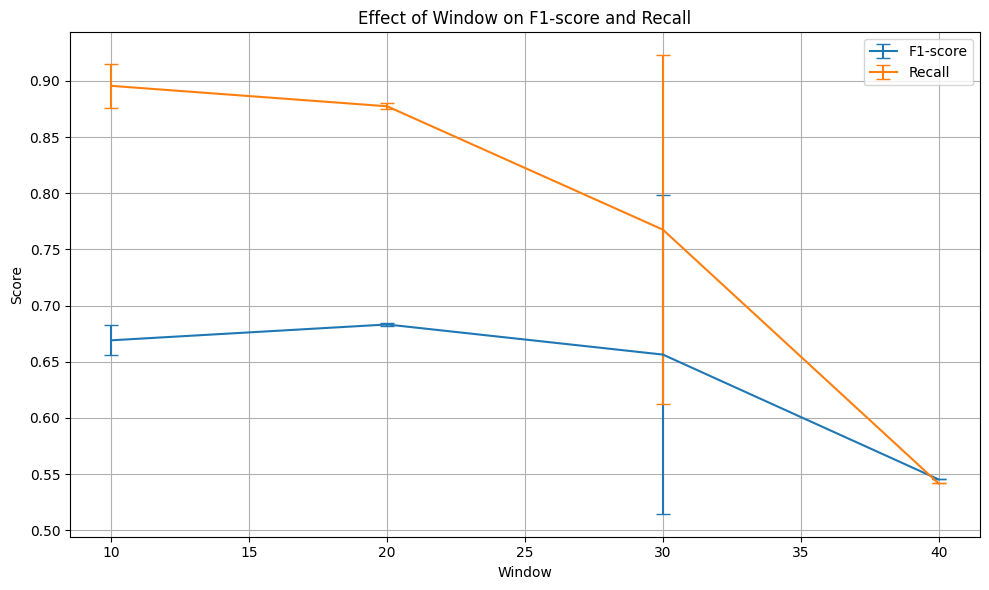

In [ ]:
plot_f1_recall_by_group(Optimized_models_results_df, group_col="Window")

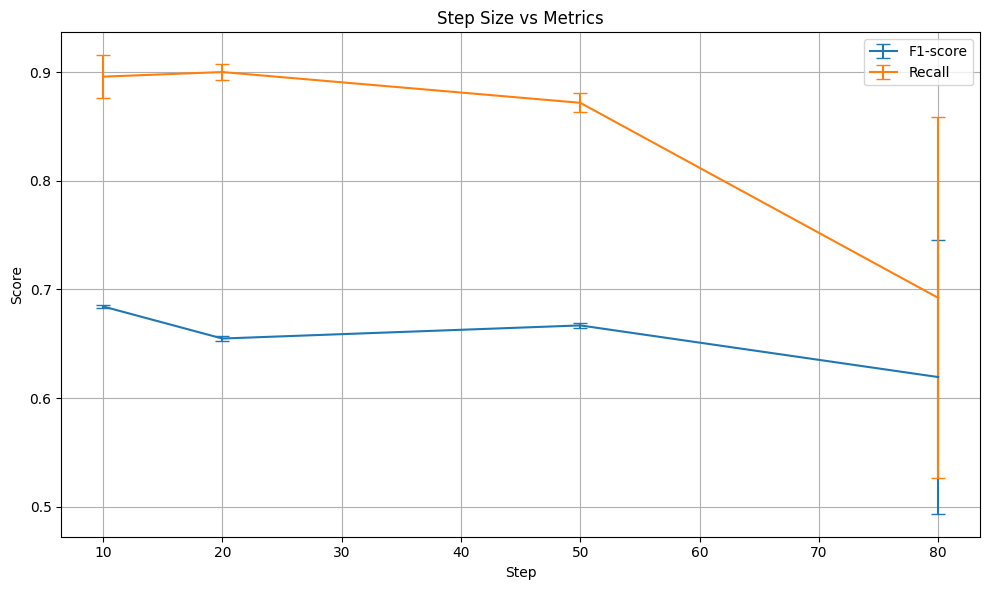

In [ ]:
plot_f1_recall_by_group(Optimized_models_results_df, group_col="Step", title="Effect of Step on F1-score and Recall")

# Best Result Model

## Features importance

In [90]:
first_row = Optimized_models_results_df.iloc[0]

# Iterate through the columns and output
for col in Optimized_models_results_df.columns:
    print(f"{col}: {first_row[col]}")

Unnamed: 0: 0
Model: LR
Window: 30
Step: 80
params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9197191697191696
Recall: 0.925925925925926
Precision: 0.7079463364293086
F1-score: 0.7964805740111635
ROC_AUC: 0.9615600448933782
Model_Combo: LR_W30_S80


In [10]:
df_3080 = unify_dataset_length(xls.sheet_names,30,80)

In [15]:
# Features Importance

X = df_3080.drop(["Label", "Subject", "Gender"], axis=1)
y = df_3080['Label']
groups = df_3080['Subject']
feature_names = X.columns

# Specified optimal parameters
best_params = {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
model = LogisticRegression(**best_params, max_iter=1000)

n_splits = 3
all_coefficients = []

# GroupKFold
gkf = GroupKFold(n_splits=n_splits)
for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
    X_train_raw, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test_raw, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # SMOTE
    smote = SMOTE(random_state=42)
    X_resampled_raw, y_resampled = smote.fit_resample(X_train_raw, y_train)

    # Standardisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_resampled_raw)
    X_test = scaler.transform(X_test_raw)

    # Model training
    model.fit(X_train, y_resampled)

    # Extraction factor
    all_coefficients.append(model.coef_[0])

# Calculate average coefficients and generate DataFrame
avg_coef = np.mean(all_coefficients, axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': avg_coef,
    'Importance': np.abs(avg_coef)
}).sort_values(by='Importance', ascending=False)

print(importance_df)

        Feature  Coefficient  Importance
7       HHb_min     4.133529    4.133529
8       HHb_max    -3.465820    3.465820
4   O2Hb_median    -3.353907    3.353907
3      O2Hb_max     3.336665    3.336665
1      O2Hb_std    -2.346374    2.346374
11      tHb_std     1.818618    1.818618
6       HHb_std    -1.593986    1.593986
0     O2Hb_mean    -1.582082    1.582082
2      O2Hb_min     1.522601    1.522601
9    HHb_median    -1.209107    1.209107
10     tHb_mean    -1.108913    1.108913
13      tHb_max    -0.219291    0.219291
12      tHb_min     0.111179    0.111179
14   tHb_median    -0.073920    0.073920
5      HHb_mean     0.035751    0.035751


In [ ]:
# Calculate average coefficients and generate DataFrame
avg_coef = np.mean(all_coefficients, axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': avg_coef,
    'Importance': np.abs(avg_coef)
}).sort_values(by='Importance', ascending=False)

# output result
print(importance_df)

In [ ]:
# 可视化前 20 个特征的重要性
top_k = 15
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_k))
plt.title('Top 20 Feature Importances from Logistic Regression')
plt.tight_layout()
plt.show()

## Radar chart

In [ ]:
def plot_model_radar(metrics_dict, model_name="Model"):
    """
    Plots a radar chart for a single model's performance metrics with legend placed outside the plot.
    """
    labels = list(metrics_dict.keys())
    values = list(metrics_dict.values())

    # Close the radar loop
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
    ax.fill(angles, values, alpha=0.25)

    # Axis setup
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f"{model_name} Metrics Radar", size=14, pad=20)
    ax.set_ylim(0, 1)
    ax.grid(True)

    # Adjust legend position to be outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.05))

    plt.tight_layout()

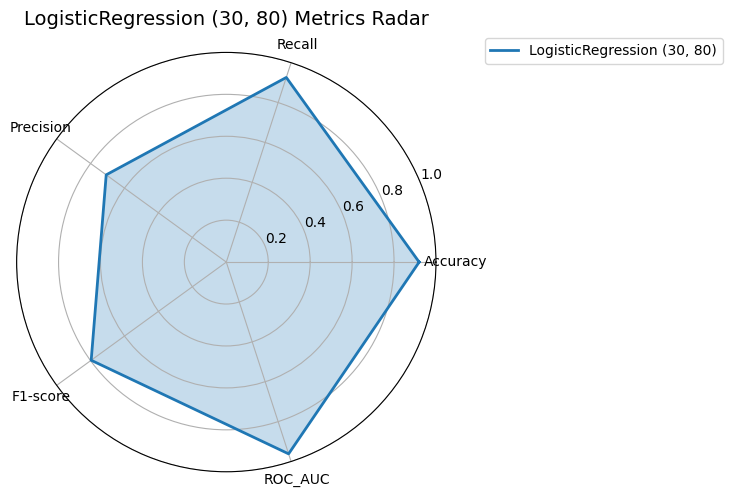

In [ ]:
row0 = Optimized_models_results_df.iloc[0]
metrics = {
    'Accuracy': row0['Accuracy'],
    'Recall': row0['Recall'],
    'Precision': row0['Precision'],
    'F1-score': row0['F1-score'],
    'ROC_AUC': row0['ROC_AUC']
}

model_name = f"{row0['Model']} ({row0['Window']}, {row0['Step']})"

plot_model_radar(metrics, model_name=model_name)

## Confusion Matrix

In [ ]:
lr_3080_df

,Model,Window,Step,params,Accuracy,Recall,Precision,F1-score,ROC_AUC
0,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.919719,0.925926,0.707946,0.796481,0.961560
1,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.917582,0.912037,0.704678,0.789423,0.961455
2,LogisticRegression,30,80,"{'C': 10, 'penalty': 'l2', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841
3,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.961841
4,LogisticRegression,30,80,"{'C': 10, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}",0.917582,0.912037,0.704678,0.789423,0.960683


In [ ]:
features = [f for f in df_3080.columns[3:]]

Text(0.5, 1.0, 'Confusion Matrix - LogisticRegression_After_GridSearchCV - Window_size=30&Step=80 ')

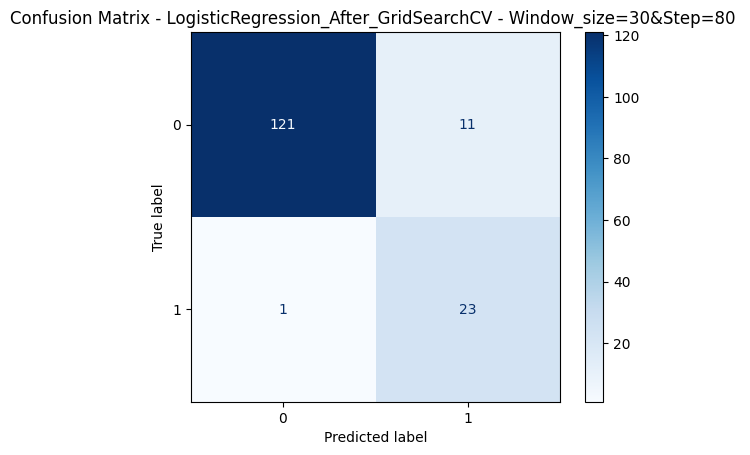

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_lr_3080 = confusion_matrix(lr_3080_ytest, lr_3080_ypred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_3080)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - LogisticRegression_After_GridSearchCV - Window_size=30&Step=80 ")

## Features plot

<Axes: xlabel='Gender', ylabel='count'>

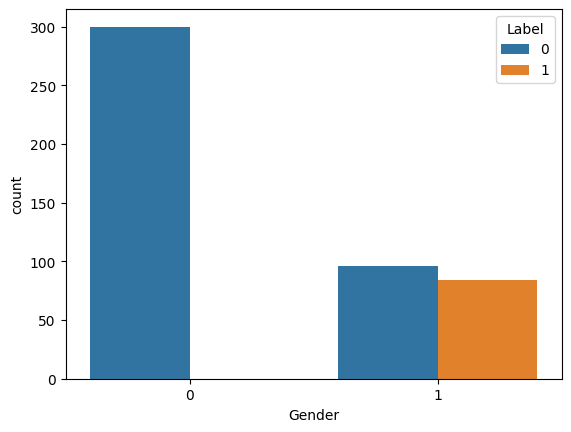

In [ ]:
sns.countplot(x='Gender', hue='Label', data=df_3080)

In [ ]:
df_filter_result[(df_filter_result["Model"] == "LogisticRegression") &
                 (df_filter_result["Window"] == 30) &
                 (df_filter_result["Step"] == 80)]["Best_k"]

,Best_k
0,15


In [ ]:
df_3080.head(3)

,Subject,Label,Gender,HHb_std,O2Hb_max,tHb_max,tHb_min,tHb_median,O2Hb_median,tHb_mean,O2Hb_mean,HHb_max,O2Hb_min,HHb_median,O2Hb_std,HHb_mean,HHb_min,tHb_std
0,1,0,0,0.346397,0.573559,1.510213,0.947385,1.183154,0.323704,1.166384,0.133626,1.948666,-0.680656,0.924711,0.370890,1.032658,0.665091,0.105439
1,1,0,0,0.928890,0.572678,4.248937,3.386006,3.789117,-0.753838,3.731003,-0.882374,6.524301,-2.510021,4.490982,0.855091,4.613277,3.532837,0.195298
2,1,0,0,1.085548,-1.792213,3.834065,3.328992,3.584611,-2.979013,3.555375,-3.106001,8.770542,-4.936573,6.606265,1.040695,6.661277,5.165529,0.120348


In [ ]:
O2Hb_features_names_lr_3080 = ['O2Hb_min', 'O2Hb_max', 'O2Hb_median', 'O2Hb_mean', 'O2Hb_std']
HHb_features_names_lr_3080 = ['HHb_min', 'HHb_max', 'HHb_median', 'HHb_mean', 'HHb_std']
tHb_features_names_lr_3080 = ['tHb_min', 'tHb_max', 'tHb_median', 'tHb_mean', 'tHb_std']

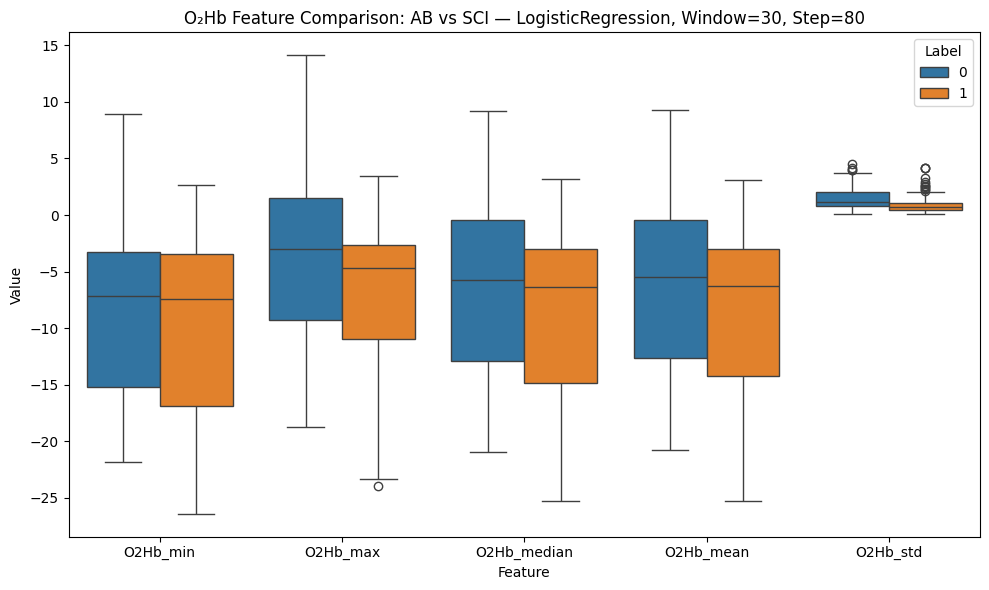

In [ ]:
plot_features_vs_label(df_3080, O2Hb_features_names_lr_3080, "O₂Hb Feature Comparison: AB vs SCI — LogisticRegression, Window=30, Step=80")

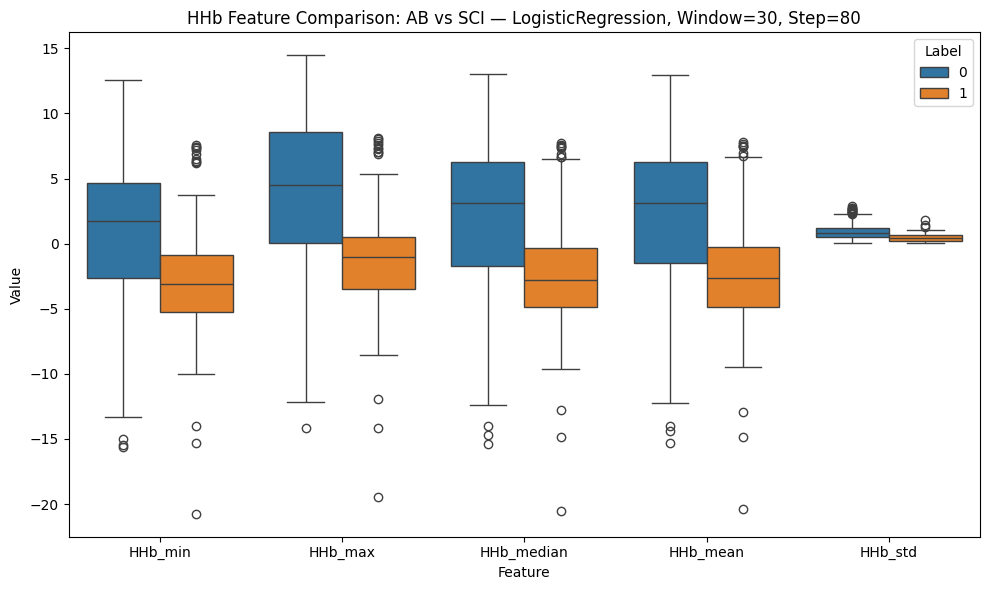

In [ ]:
plot_features_vs_label(df_3080, HHb_features_names_lr_3080, "HHb Feature Comparison: AB vs SCI — LogisticRegression, Window=30, Step=80")

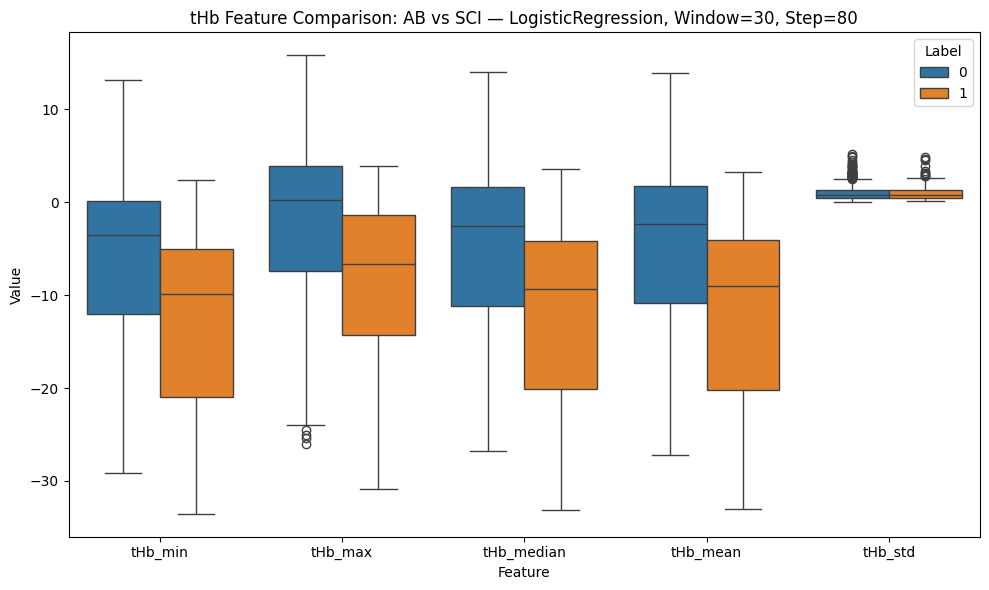

In [ ]:
plot_features_vs_label(df_3080, tHb_features_names_lr_3080, "tHb Feature Comparison: AB vs SCI — LogisticRegression, Window=30, Step=80")